# 📈 Apple Stock Market Forecasting — ML-Based Analysis
**Internal Assessment Project | Financial Data Analysis**

---
**Models Used:** Random Forest · XGBoost · LSTM (Deep Learning)  
**Data Source:** Yahoo Finance API (`yfinance`)  
**Target:** Predict next day's closing price for AAPL  

---

## 📦 Cell 1 — Install & Import Libraries

In [1]:
# Install required libraries (run once)
!pip install yfinance xgboost scikit-learn tensorflow plotly statsmodels mplfinance seaborn --quiet

## 📚 Cell 2 — Import All Libraries

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import mplfinance as mpf
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import xgboost as xgb

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Style settings
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['axes.facecolor'] = '#0d1117'
plt.rcParams['figure.facecolor'] = '#0d1117'
plt.rcParams['axes.edgecolor'] = '#30363d'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plt.rcParams['text.color'] = 'white'
plt.rcParams['grid.color'] = '#21262d'
plt.rcParams['grid.linewidth'] = 0.8
sns.set_palette('husl')

print('✅ All libraries imported successfully!')
print(f'TensorFlow version: {tf.__version__}')

✅ All libraries imported successfully!
TensorFlow version: 2.20.0


---
## 📥 Cell 3 — Fetch Apple Stock Data from Yahoo Finance

In [3]:
# ─── Fetch AAPL data ──────────────────────────────────────────────────────────
TICKER = 'AAPL'
START_DATE = '2018-01-01'
END_DATE   = pd.Timestamp.today().strftime('%Y-%m-%d')

print(f'📡 Fetching {TICKER} data from {START_DATE} to {END_DATE} ...')
df = yf.download(TICKER, start=START_DATE, end=END_DATE, auto_adjust=True)
df.columns = df.columns.droplevel(1) if isinstance(df.columns, pd.MultiIndex) else df.columns
df.index = pd.to_datetime(df.index)

# Also fetch company info
aapl = yf.Ticker(TICKER)
info = aapl.info

print(f'\n🍎 Company: {info.get("longName", "Apple Inc.")}')
print(f'📊 Sector: {info.get("sector", "Technology")}')
print(f'💰 Market Cap: ${info.get("marketCap", 0)/1e12:.2f}T')
print(f'📅 Data Shape: {df.shape[0]} trading days × {df.shape[1]} columns')
print(f'📆 Date Range: {df.index[0].date()} → {df.index[-1].date()}')
print('\n', df.tail())

📡 Fetching AAPL data from 2018-01-01 to 2026-02-18 ...


[*********************100%***********************]  1 of 1 completed



🍎 Company: Apple Inc.
📊 Sector: Technology
💰 Market Cap: $3.91T
📅 Data Shape: 2042 trading days × 5 columns
📆 Date Range: 2018-01-02 → 2026-02-17

 Price            Close        High         Low        Open    Volume
Date                                                                
2026-02-10  273.679993  275.369995  272.940002  274.890015  34376900
2026-02-11  275.500000  280.179993  274.450012  274.700012  51931300
2026-02-12  261.730011  275.720001  260.179993  275.589996  81077200
2026-02-13  255.779999  262.230011  255.449997  262.010010  56229900
2026-02-17  266.069885  266.089996  255.539993  258.049988  27759956


---
## 📊 Cell 4 — Exploratory Data Analysis (EDA)

In [4]:
print('━━━ Basic Statistics ━━━')
print(df.describe().round(2))
print(f'\n🔍 Missing values: {df.isnull().sum().sum()}')
print(f'📈 All-time High Close: ${df["Close"].max():.2f} on {df["Close"].idxmax().date()}')
print(f'📉 All-time Low Close:  ${df["Close"].min():.2f} on {df["Close"].idxmin().date()}')
print(f'📊 Average Daily Volume: {df["Volume"].mean()/1e6:.2f}M shares')

━━━ Basic Statistics ━━━
Price    Close     High      Low     Open        Volume
count  2042.00  2042.00  2042.00  2042.00  2.042000e+03
mean    137.31   138.71   135.79   137.19  9.381082e+07
std      68.04    68.65    67.38    67.99  5.432055e+07
min      33.77    34.61    33.72    34.19  1.791060e+07
25%      65.26    65.81    64.11    64.81  5.493402e+07
50%     143.52   145.11   142.19   143.35  8.034650e+07
75%     185.68   187.28   184.12   185.74  1.143827e+08
max     285.92   288.35   283.04   285.93  4.265100e+08

🔍 Missing values: 0
📈 All-time High Close: $285.92 on 2025-12-02
📉 All-time Low Close:  $33.77 on 2019-01-03
📊 Average Daily Volume: 93.81M shares


---
## 📈 Cell 5 — Interactive Candlestick Chart (Plotly)

In [5]:
# ─── Interactive Candlestick + Volume ─────────────────────────────────────────
fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
                    vertical_spacing=0.03,
                    row_heights=[0.75, 0.25],
                    subplot_titles=['🍎 AAPL Price (Candlestick)', 'Volume'])

fig.add_trace(go.Candlestick(
    x=df.index, open=df['Open'], high=df['High'],
    low=df['Low'], close=df['Close'],
    increasing_line_color='#00d084', decreasing_line_color='#ff4d4d',
    name='AAPL'
), row=1, col=1)

colors = ['#00d084' if c >= o else '#ff4d4d'
          for c, o in zip(df['Close'], df['Open'])]
fig.add_trace(go.Bar(
    x=df.index, y=df['Volume'],
    marker_color=colors, name='Volume', opacity=0.7
), row=2, col=1)

fig.update_layout(
    title=dict(text='Apple Inc. (AAPL) — Full Historical Price & Volume', font=dict(size=18)),
    template='plotly_dark',
    xaxis_rangeslider_visible=False,
    height=700,
    showlegend=False
)
fig.show()

---
## 📉 Cell 6 — Returns, Volatility & Distribution

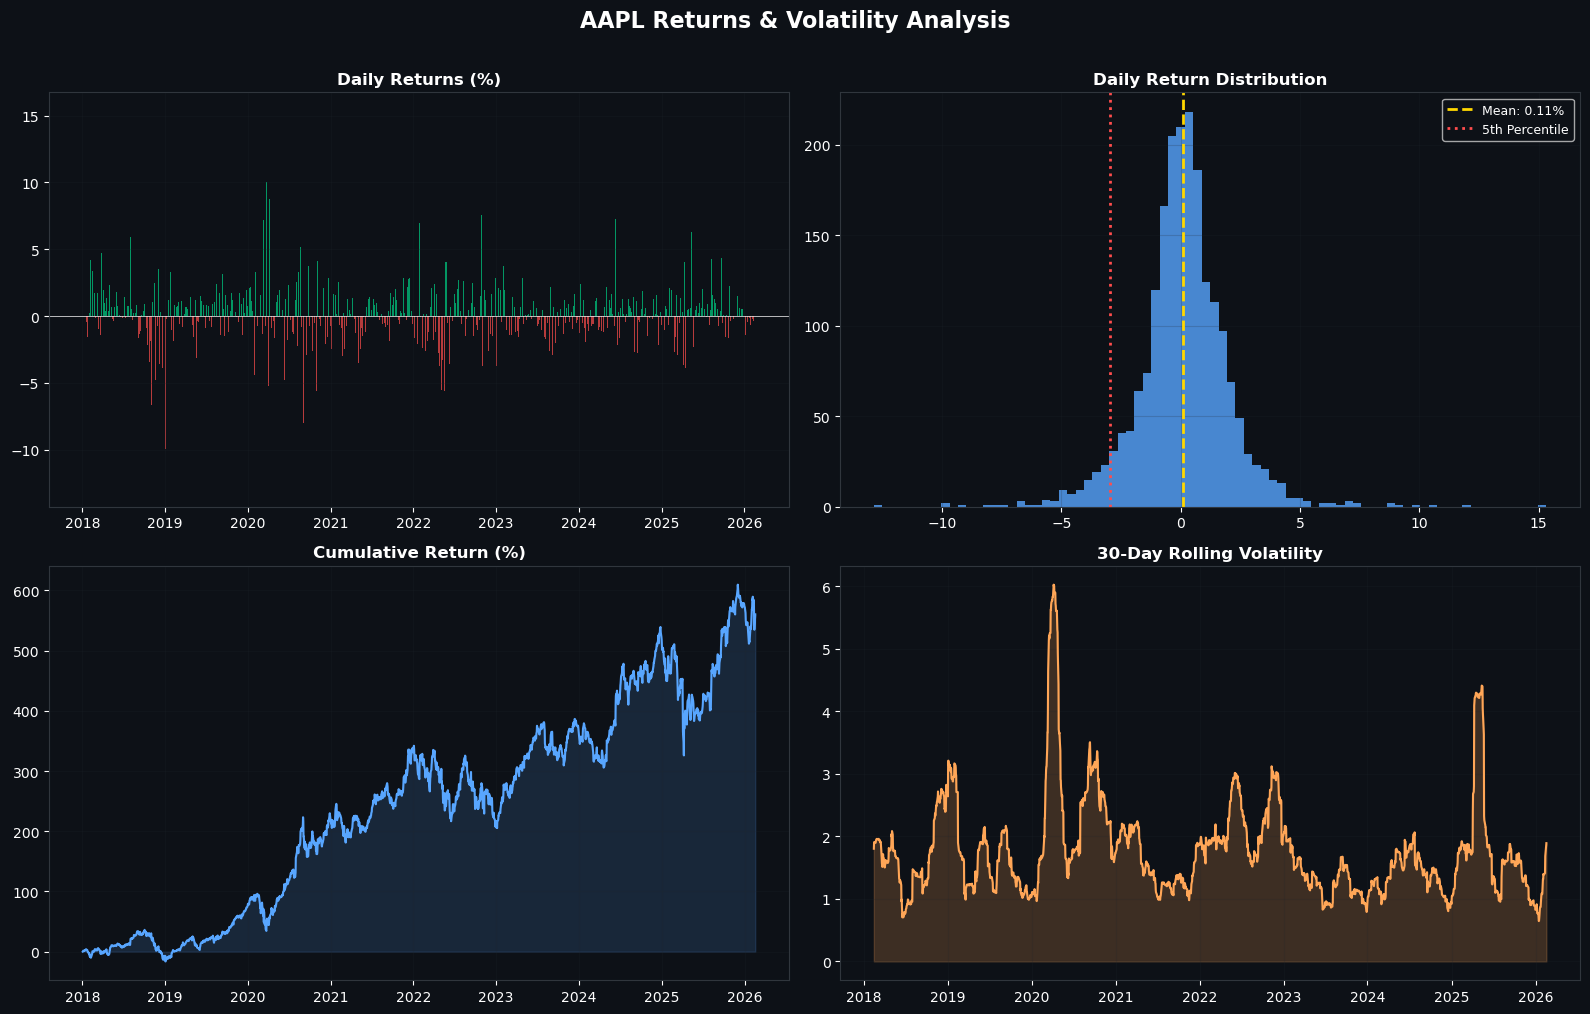


📊 Return Statistics:
  Average Daily Return : 0.111%
  Std Deviation        : 1.938%
  Skewness             : 0.154
  Best Day             : +15.33% on 2025-04-09
  Worst Day            : -12.86% on 2020-03-16


In [6]:
# ─── Daily Returns Analysis ────────────────────────────────────────────────────
df['Daily_Return'] = df['Close'].pct_change() * 100
df['Cumulative_Return'] = (1 + df['Daily_Return']/100).cumprod() - 1
df['Rolling_Volatility_30d'] = df['Daily_Return'].rolling(30).std()

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.patch.set_facecolor('#0d1117')
fig.suptitle('AAPL Returns & Volatility Analysis', fontsize=16, fontweight='bold', color='white', y=1.01)

# 1. Daily Returns
ax = axes[0, 0]
ax.set_facecolor('#0d1117')
positive = df['Daily_Return'][df['Daily_Return'] >= 0]
negative = df['Daily_Return'][df['Daily_Return'] < 0]
ax.bar(positive.index, positive, color='#00d084', alpha=0.7, width=1)
ax.bar(negative.index, negative, color='#ff4d4d', alpha=0.7, width=1)
ax.set_title('Daily Returns (%)', color='white', fontweight='bold')
ax.axhline(0, color='white', lw=0.5)
ax.grid(True, alpha=0.2)

# 2. Return Distribution
ax = axes[0, 1]
ax.set_facecolor('#0d1117')
ax.hist(df['Daily_Return'].dropna(), bins=80, color='#58a6ff', alpha=0.8, edgecolor='none')
ax.axvline(df['Daily_Return'].mean(), color='#ffd700', lw=2, linestyle='--', label=f'Mean: {df["Daily_Return"].mean():.2f}%')
ax.axvline(df['Daily_Return'].quantile(0.05), color='#ff4d4d', lw=2, linestyle=':', label='5th Percentile')
ax.set_title('Daily Return Distribution', color='white', fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.2)

# 3. Cumulative Return
ax = axes[1, 0]
ax.set_facecolor('#0d1117')
ax.plot(df.index, df['Cumulative_Return']*100, color='#58a6ff', lw=1.5)
ax.fill_between(df.index, df['Cumulative_Return']*100, alpha=0.15, color='#58a6ff')
ax.set_title('Cumulative Return (%)', color='white', fontweight='bold')
ax.grid(True, alpha=0.2)

# 4. 30-day Rolling Volatility
ax = axes[1, 1]
ax.set_facecolor('#0d1117')
ax.plot(df.index, df['Rolling_Volatility_30d'], color='#ffa657', lw=1.5)
ax.fill_between(df.index, df['Rolling_Volatility_30d'], alpha=0.2, color='#ffa657')
ax.set_title('30-Day Rolling Volatility', color='white', fontweight='bold')
ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

print(f'\n📊 Return Statistics:')
print(f'  Average Daily Return : {df["Daily_Return"].mean():.3f}%')
print(f'  Std Deviation        : {df["Daily_Return"].std():.3f}%')
print(f'  Skewness             : {df["Daily_Return"].skew():.3f}')
print(f'  Best Day             : +{df["Daily_Return"].max():.2f}% on {df["Daily_Return"].idxmax().date()}')
print(f'  Worst Day            : {df["Daily_Return"].min():.2f}% on {df["Daily_Return"].idxmin().date()}')

---
## 🔥 Cell 7 — Correlation Heatmap

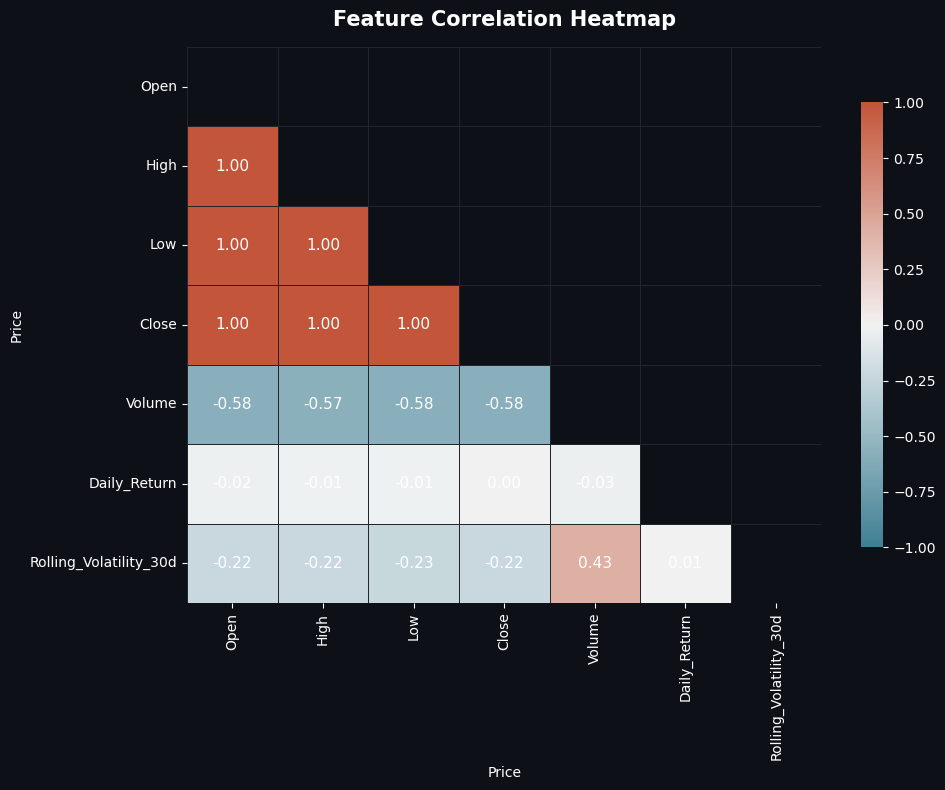

In [7]:
# ─── Correlation Heatmap ───────────────────────────────────────────────────────
corr_data = df[['Open', 'High', 'Low', 'Close', 'Volume', 'Daily_Return', 'Rolling_Volatility_30d']].dropna()
corr = corr_data.corr()

fig, ax = plt.subplots(figsize=(10, 8))
fig.patch.set_facecolor('#0d1117')
ax.set_facecolor('#0d1117')

mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            annot=True, fmt='.2f', linewidths=0.5, linecolor='#21262d',
            ax=ax, cbar_kws={'shrink': 0.8},
            annot_kws={'color': 'white', 'fontsize': 11})

ax.set_title('Feature Correlation Heatmap', color='white', fontsize=15, fontweight='bold', pad=15)
ax.tick_params(colors='white')
plt.tight_layout()
plt.show()

---
## 📅 Cell 8 — Trend & Seasonality Decomposition

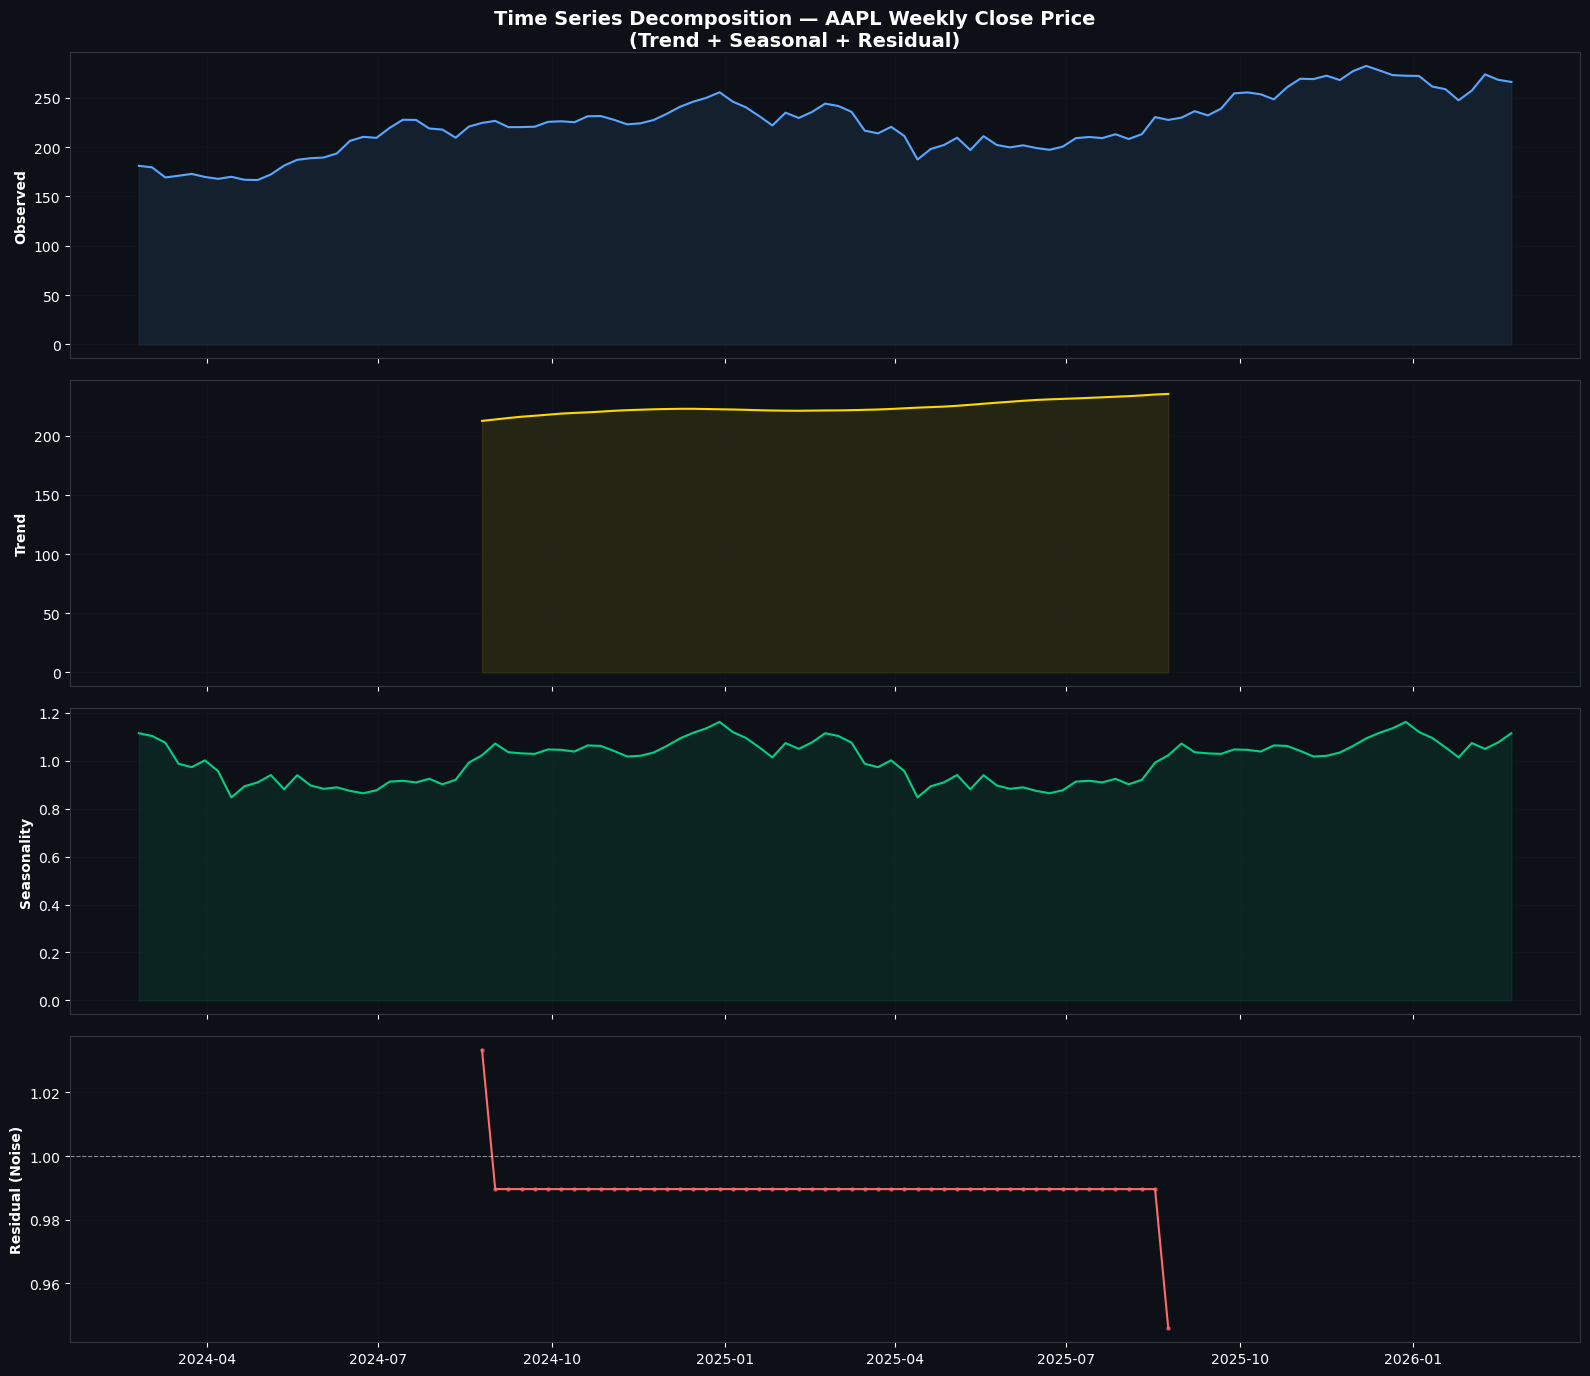

In [8]:
# ─── Seasonal Decomposition ────────────────────────────────────────────────────
# Use last 2 years of data for cleaner decomposition
recent = df['Close'].last('730D').resample('W').mean().dropna()
decomp = seasonal_decompose(recent, model='multiplicative', period=52)

fig, axes = plt.subplots(4, 1, figsize=(16, 14), sharex=True)
fig.patch.set_facecolor('#0d1117')
fig.suptitle('Time Series Decomposition — AAPL Weekly Close Price\n(Trend + Seasonal + Residual)', 
             fontsize=14, fontweight='bold', color='white')

components = [
    ('Observed', decomp.observed, '#58a6ff'),
    ('Trend', decomp.trend, '#ffd700'),
    ('Seasonality', decomp.seasonal, '#00d084'),
    ('Residual (Noise)', decomp.resid, '#ff6b6b'),
]

for ax, (title, data, color) in zip(axes, components):
    ax.set_facecolor('#0d1117')
    ax.plot(data.index, data, color=color, lw=1.5)
    if title != 'Residual (Noise)':
        ax.fill_between(data.index, data, alpha=0.1, color=color)
    else:
        ax.axhline(1, color='white', lw=0.8, linestyle='--', alpha=0.5)
        ax.scatter(data.index, data, color=color, s=5, alpha=0.6)
    ax.set_ylabel(title, color='white', fontweight='bold', fontsize=10)
    ax.grid(True, alpha=0.2)
    ax.tick_params(colors='white')

plt.tight_layout()
plt.show()

---
## 📆 Cell 9 — Monthly & Day-of-Week Patterns

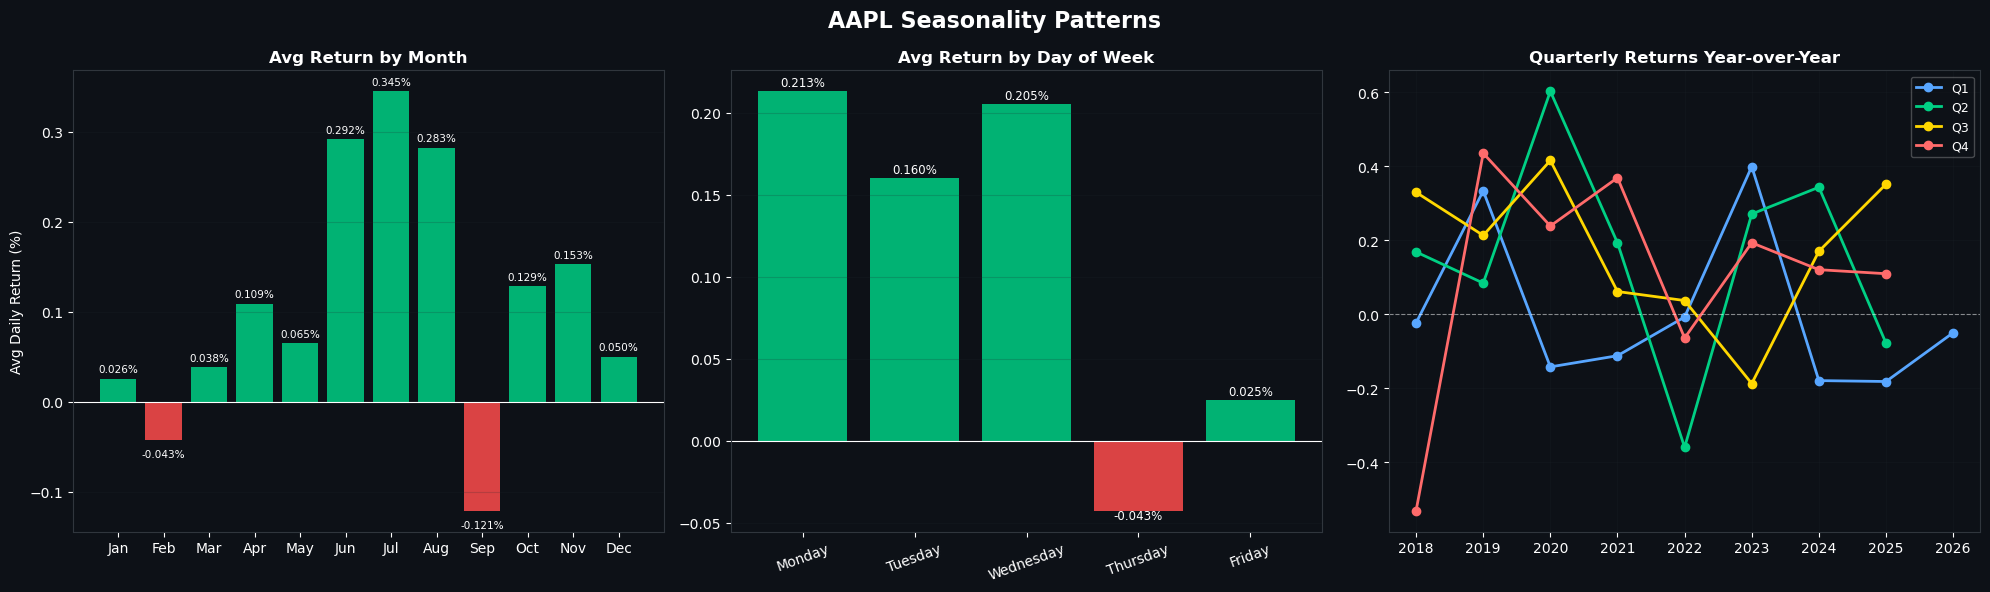

In [9]:
# ─── Seasonality Patterns ─────────────────────────────────────────────────────
df_copy = df.copy()
df_copy['Month'] = df_copy.index.month
df_copy['Month_Name'] = df_copy.index.strftime('%b')
df_copy['DayOfWeek'] = df_copy.index.day_name()
df_copy['Year'] = df_copy.index.year
df_copy['Quarter'] = df_copy.index.quarter

month_order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
day_order   = ['Monday','Tuesday','Wednesday','Thursday','Friday']

monthly_ret = df_copy.groupby('Month_Name')['Daily_Return'].mean().reindex(month_order)
daily_ret   = df_copy.groupby('DayOfWeek')['Daily_Return'].mean().reindex(day_order)
qtr_ret     = df_copy.groupby(['Year','Quarter'])['Daily_Return'].mean().unstack()

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.patch.set_facecolor('#0d1117')
fig.suptitle('AAPL Seasonality Patterns', fontsize=16, fontweight='bold', color='white')

# Monthly pattern
ax = axes[0]
ax.set_facecolor('#0d1117')
colors_m = ['#00d084' if v >= 0 else '#ff4d4d' for v in monthly_ret]
bars = ax.bar(monthly_ret.index, monthly_ret.values, color=colors_m, alpha=0.85, edgecolor='none')
ax.axhline(0, color='white', lw=0.8)
ax.set_title('Avg Return by Month', color='white', fontweight='bold')
ax.set_ylabel('Avg Daily Return (%)', color='white')
ax.grid(True, alpha=0.2, axis='y')
ax.tick_params(colors='white', axis='both')
for bar, val in zip(bars, monthly_ret.values):
    ax.text(bar.get_x() + bar.get_width()/2, val + (0.005 if val >= 0 else -0.01),
            f'{val:.3f}%', ha='center', va='bottom' if val >= 0 else 'top',
            fontsize=7.5, color='white')

# Day-of-week pattern
ax = axes[1]
ax.set_facecolor('#0d1117')
colors_d = ['#00d084' if v >= 0 else '#ff4d4d' for v in daily_ret]
bars = ax.bar(daily_ret.index, daily_ret.values, color=colors_d, alpha=0.85, edgecolor='none')
ax.axhline(0, color='white', lw=0.8)
ax.set_title('Avg Return by Day of Week', color='white', fontweight='bold')
ax.grid(True, alpha=0.2, axis='y')
ax.tick_params(colors='white', axis='both')
ax.tick_params(axis='x', rotation=20)
for bar, val in zip(bars, daily_ret.values):
    ax.text(bar.get_x() + bar.get_width()/2, val + (0.003 if val >= 0 else -0.005),
            f'{val:.3f}%', ha='center', fontsize=8.5, color='white')

# Year-over-year quarterly
ax = axes[2]
ax.set_facecolor('#0d1117')
qtr_colors = ['#58a6ff','#00d084','#ffd700','#ff6b6b']
for i, q in enumerate(qtr_ret.columns):
    ax.plot(qtr_ret.index, qtr_ret[q], marker='o', lw=2,
            color=qtr_colors[i], label=f'Q{q}', markersize=6)
ax.axhline(0, color='white', lw=0.8, linestyle='--', alpha=0.5)
ax.set_title('Quarterly Returns Year-over-Year', color='white', fontweight='bold')
ax.legend(fontsize=9, framealpha=0.3)
ax.grid(True, alpha=0.2)
ax.tick_params(colors='white')

plt.tight_layout()
plt.show()

---
## 📐 Cell 10 — Technical Indicators

In [10]:
# ─── Compute Technical Indicators ─────────────────────────────────────────────
def add_technical_indicators(df):
    d = df.copy()

    # Moving Averages
    for w in [7, 20, 50, 200]:
        d[f'MA_{w}'] = d['Close'].rolling(w).mean()
        d[f'EMA_{w}'] = d['Close'].ewm(span=w, adjust=False).mean()

    # Bollinger Bands (20-day)
    d['BB_mid']  = d['Close'].rolling(20).mean()
    d['BB_std']  = d['Close'].rolling(20).std()
    d['BB_upper']= d['BB_mid'] + 2*d['BB_std']
    d['BB_lower']= d['BB_mid'] - 2*d['BB_std']
    d['BB_width']= (d['BB_upper'] - d['BB_lower']) / d['BB_mid']

    # RSI (14-day)
    delta = d['Close'].diff()
    gain  = delta.clip(lower=0)
    loss  = -delta.clip(upper=0)
    avg_gain = gain.rolling(14).mean()
    avg_loss = loss.rolling(14).mean()
    rs = avg_gain / avg_loss
    d['RSI'] = 100 - (100 / (1 + rs))

    # MACD
    ema12 = d['Close'].ewm(span=12, adjust=False).mean()
    ema26 = d['Close'].ewm(span=26, adjust=False).mean()
    d['MACD']        = ema12 - ema26
    d['MACD_signal'] = d['MACD'].ewm(span=9, adjust=False).mean()
    d['MACD_hist']   = d['MACD'] - d['MACD_signal']

    # ATR (Average True Range)
    high_low  = d['High'] - d['Low']
    high_close= (d['High'] - d['Close'].shift()).abs()
    low_close = (d['Low']  - d['Close'].shift()).abs()
    d['ATR'] = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1).rolling(14).mean()

    # On-Balance Volume
    d['OBV'] = (np.sign(d['Close'].diff()) * d['Volume']).fillna(0).cumsum()

    # Price relative features
    d['Pct_from_52w_high'] = d['Close'] / d['High'].rolling(252).max() - 1
    d['Price_range']       = (d['High'] - d['Low']) / d['Close']

    # Lag features
    for lag in [1, 2, 3, 5, 10]:
        d[f'Close_lag_{lag}']  = d['Close'].shift(lag)
        d[f'Return_lag_{lag}'] = d['Daily_Return'].shift(lag)

    # Rolling stats
    for w in [5, 10, 20]:
        d[f'Rolling_mean_{w}'] = d['Close'].rolling(w).mean()
        d[f'Rolling_std_{w}']  = d['Close'].rolling(w).std()

    # Calendar features
    d['DayOfWeek'] = d.index.dayofweek
    d['Month']     = d.index.month
    d['Quarter']   = d.index.quarter
    d['IsMonthEnd']= d.index.is_month_end.astype(int)
    d['IsMonthStart'] = d.index.is_month_start.astype(int)

    return d

df = add_technical_indicators(df)
print(f'✅ Technical indicators added! Dataset shape: {df.shape}')
print(f'📐 Columns: {list(df.columns)}')

✅ Technical indicators added! Dataset shape: (2042, 50)
📐 Columns: ['Close', 'High', 'Low', 'Open', 'Volume', 'Daily_Return', 'Cumulative_Return', 'Rolling_Volatility_30d', 'MA_7', 'EMA_7', 'MA_20', 'EMA_20', 'MA_50', 'EMA_50', 'MA_200', 'EMA_200', 'BB_mid', 'BB_std', 'BB_upper', 'BB_lower', 'BB_width', 'RSI', 'MACD', 'MACD_signal', 'MACD_hist', 'ATR', 'OBV', 'Pct_from_52w_high', 'Price_range', 'Close_lag_1', 'Return_lag_1', 'Close_lag_2', 'Return_lag_2', 'Close_lag_3', 'Return_lag_3', 'Close_lag_5', 'Return_lag_5', 'Close_lag_10', 'Return_lag_10', 'Rolling_mean_5', 'Rolling_std_5', 'Rolling_mean_10', 'Rolling_std_10', 'Rolling_mean_20', 'Rolling_std_20', 'DayOfWeek', 'Month', 'Quarter', 'IsMonthEnd', 'IsMonthStart']


---
## 📊 Cell 11 — Technical Indicators Visualization

In [11]:
# ─── Plot Technical Indicators (last 12 months) ───────────────────────────────
plot_df = df.last('365D')

fig = make_subplots(rows=4, cols=1, shared_xaxes=True,
                    vertical_spacing=0.04,
                    row_heights=[0.45, 0.2, 0.175, 0.175],
                    subplot_titles=['Price + Bollinger Bands + Moving Averages',
                                    'Volume + OBV', 'RSI (14)', 'MACD'])

# Row 1: Price + MAs + Bollinger
fig.add_trace(go.Candlestick(x=plot_df.index, open=plot_df['Open'], high=plot_df['High'],
    low=plot_df['Low'], close=plot_df['Close'],
    increasing_line_color='#00d084', decreasing_line_color='#ff4d4d', name='AAPL'), row=1, col=1)

for ma, color in [('MA_20','#58a6ff'),('MA_50','#ffd700'),('MA_200','#ff6b6b')]:
    fig.add_trace(go.Scatter(x=plot_df.index, y=plot_df[ma], name=ma,
                             line=dict(color=color, width=1.5)), row=1, col=1)

fig.add_trace(go.Scatter(x=plot_df.index, y=plot_df['BB_upper'], name='BB Upper',
    line=dict(color='#888', width=1, dash='dot'), showlegend=False), row=1, col=1)
fig.add_trace(go.Scatter(x=plot_df.index, y=plot_df['BB_lower'], name='BB Lower',
    fill='tonexty', fillcolor='rgba(100,100,255,0.08)',
    line=dict(color='#888', width=1, dash='dot'), showlegend=False), row=1, col=1)

# Row 2: Volume
vol_colors = ['#00d084' if c >= o else '#ff4d4d' for c, o in zip(plot_df['Close'], plot_df['Open'])]
fig.add_trace(go.Bar(x=plot_df.index, y=plot_df['Volume'], marker_color=vol_colors,
                     opacity=0.6, name='Volume'), row=2, col=1)

# Row 3: RSI
fig.add_trace(go.Scatter(x=plot_df.index, y=plot_df['RSI'], name='RSI',
                         line=dict(color='#a78bfa', width=1.5)), row=3, col=1)
fig.add_hline(y=70, line_dash='dash', line_color='#ff4d4d', line_width=1, row=3, col=1)
fig.add_hline(y=30, line_dash='dash', line_color='#00d084', line_width=1, row=3, col=1)
fig.add_hrect(y0=30, y1=70, fillcolor='rgba(255,255,255,0.03)', row=3, col=1)

# Row 4: MACD
macd_colors = ['#00d084' if v >= 0 else '#ff4d4d' for v in plot_df['MACD_hist']]
fig.add_trace(go.Bar(x=plot_df.index, y=plot_df['MACD_hist'],
                     marker_color=macd_colors, name='MACD Histogram', opacity=0.7), row=4, col=1)
fig.add_trace(go.Scatter(x=plot_df.index, y=plot_df['MACD'], name='MACD',
                         line=dict(color='#58a6ff', width=1.5)), row=4, col=1)
fig.add_trace(go.Scatter(x=plot_df.index, y=plot_df['MACD_signal'], name='Signal',
                         line=dict(color='#ffa657', width=1.5)), row=4, col=1)

fig.update_layout(template='plotly_dark', height=900,
                  title='AAPL Technical Analysis Dashboard (Last 12 Months)',
                  xaxis_rangeslider_visible=False)
fig.show()

---
## 🔧 Cell 12 — Feature Engineering & Data Preparation for ML

In [12]:
# ─── Prepare ML Dataset ────────────────────────────────────────────────────────
TARGET = 'Close'

FEATURE_COLS = [
    'Open','High','Low','Volume',
    'MA_7','MA_20','MA_50','EMA_7','EMA_20',
    'BB_upper','BB_lower','BB_width',
    'RSI','MACD','MACD_signal','MACD_hist','ATR',
    'OBV','Price_range','Pct_from_52w_high',
    'Close_lag_1','Close_lag_2','Close_lag_3','Close_lag_5',
    'Return_lag_1','Return_lag_2','Return_lag_3',
    'Rolling_mean_5','Rolling_mean_10','Rolling_std_5','Rolling_std_10',
    'Rolling_Volatility_30d',
    'DayOfWeek','Month','Quarter','IsMonthEnd','IsMonthStart'
]

ml_df = df[FEATURE_COLS + [TARGET]].dropna().copy()

X = ml_df[FEATURE_COLS]
y = ml_df[TARGET]

# ─── Train / Validation / Test Split (time-aware!) ────────────────────────────
# Test = last 60 trading days (~3 months)
# Validation = 60 days before that
n_test = 60
n_val  = 60

X_train = X.iloc[:-(n_test+n_val)]
X_val   = X.iloc[-(n_test+n_val):-n_test]
X_test  = X.iloc[-n_test:]

y_train = y.iloc[:-(n_test+n_val)]
y_val   = y.iloc[-(n_test+n_val):-n_test]
y_test  = y.iloc[-n_test:]

test_dates = X_test.index

print(f'✅ Dataset ready!')
print(f'   Train   : {len(X_train)} days  ({X_train.index[0].date()} → {X_train.index[-1].date()})')
print(f'   Val     : {len(X_val)} days  ({X_val.index[0].date()} → {X_val.index[-1].date()})')
print(f'   Test    : {len(X_test)} days  ({X_test.index[0].date()} → {X_test.index[-1].date()})')
print(f'   Features: {len(FEATURE_COLS)}')

✅ Dataset ready!
   Train   : 1671 days  (2019-01-02 → 2025-08-25)
   Val     : 60 days  (2025-08-26 → 2025-11-18)
   Test    : 60 days  (2025-11-19 → 2026-02-17)
   Features: 37


---
## 🌲 Cell 13 — Model 1: Random Forest

In [13]:
# ─── Random Forest ────────────────────────────────────────────────────────────
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=12,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features=0.7,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))
rf_pred = rf_model.predict(X_test)

rf_mae  = mean_absolute_error(y_test, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_r2   = r2_score(y_test, rf_pred)
rf_mape = np.mean(np.abs((y_test - rf_pred) / y_test)) * 100

print('🌲 Random Forest Results:')
print(f'   MAE  : ${rf_mae:.2f}')
print(f'   RMSE : ${rf_rmse:.2f}')
print(f'   MAPE : {rf_mape:.2f}%')
print(f'   R²   : {rf_r2:.4f}')

🌲 Random Forest Results:
   MAE  : $3.93
   RMSE : $4.87
   MAPE : 1.45%
   R²   : 0.7502


---
## ⚡ Cell 14 — Model 2: XGBoost

In [14]:
# ─── XGBoost ──────────────────────────────────────────────────────────────────
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.02,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)
xgb_pred = xgb_model.predict(X_test)

xgb_mae  = mean_absolute_error(y_test, xgb_pred)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
xgb_r2   = r2_score(y_test, xgb_pred)
xgb_mape = np.mean(np.abs((y_test - xgb_pred) / y_test)) * 100

print('⚡ XGBoost Results:')
print(f'   MAE  : ${xgb_mae:.2f}')
print(f'   RMSE : ${xgb_rmse:.2f}')
print(f'   MAPE : {xgb_mape:.2f}%')
print(f'   R²   : {xgb_r2:.4f}')

⚡ XGBoost Results:
   MAE  : $18.12
   RMSE : $20.16
   MAPE : 6.64%
   R²   : -3.2883


---
## 🧠 Cell 15 — Model 3: LSTM (Deep Learning)

In [16]:
# ─── LSTM Preparation ─────────────────────────────────────────────────────────
SEQUENCE_LEN = 30  # Look-back window in trading days

# Scale features and target separately
feature_scaler = MinMaxScaler()
target_scaler  = MinMaxScaler()

# Full combined data scaled
full_X = ml_df[FEATURE_COLS].values
full_y = ml_df[TARGET].values.reshape(-1, 1)

full_X_scaled = feature_scaler.fit_transform(full_X)
full_y_scaled = target_scaler.fit_transform(full_y)

def make_sequences(X, y, seq_len):
    Xs, ys = [], []
    for i in range(seq_len, len(X)):
        Xs.append(X[i-seq_len:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = make_sequences(full_X_scaled, full_y_scaled, SEQUENCE_LEN)

# Split (time-aware)
train_end = len(X_seq) - n_test - n_val
val_end   = len(X_seq) - n_test

X_tr_lstm = X_seq[:train_end]
y_tr_lstm = y_seq[:train_end]
X_vl_lstm = X_seq[train_end:val_end]
y_vl_lstm = y_seq[train_end:val_end]
X_te_lstm = X_seq[val_end:]
y_te_lstm = y_seq[val_end:]

print(f'LSTM Sequences → Train: {X_tr_lstm.shape}, Val: {X_vl_lstm.shape}, Test: {X_te_lstm.shape}')

LSTM Sequences → Train: (1641, 30, 37), Val: (60, 30, 37), Test: (60, 30, 37)


In [17]:
# ─── Build & Train LSTM ───────────────────────────────────────────────────────
tf.random.set_seed(42)

lstm_model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(SEQUENCE_LEN, len(FEATURE_COLS))),
    Dropout(0.2),
    BatchNormalization(),

    LSTM(64, return_sequences=True),
    Dropout(0.2),
    BatchNormalization(),

    LSTM(32, return_sequences=False),
    Dropout(0.15),

    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)
])

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='huber')
lstm_model.summary()

callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6, verbose=1)
]

history = lstm_model.fit(
    X_tr_lstm, y_tr_lstm,
    validation_data=(X_vl_lstm, y_vl_lstm),
    epochs=100, batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 128)             │          84,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 30, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 30, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 30, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 149,185 (582.75 KB)

 Trainable params: 148,801 (581.25 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0128 - val_loss: 0.0443 - learning_rate: 0.0010
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0036 - val_loss: 0.0310 - learning_rate: 0.0010
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0026 - val_loss: 0.0283 - learning_rate: 0.0010
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0020 - val_loss: 0.0162 - learning_rate: 0.0010
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0016 - val_loss: 0.0147 - learning_rate: 0.0010
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0015 - val_loss: 0.0095 - learning_rate: 0.0010
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0014 - val_loss: 0.0120 - learning_rate: 0.0010
Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0012 - val_loss: 0.0106 - learning_rate: 0.0010
Epoch 9/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0011 - val_loss: 0.0103 - learning_rate: 0.0010
Epoch 10/1

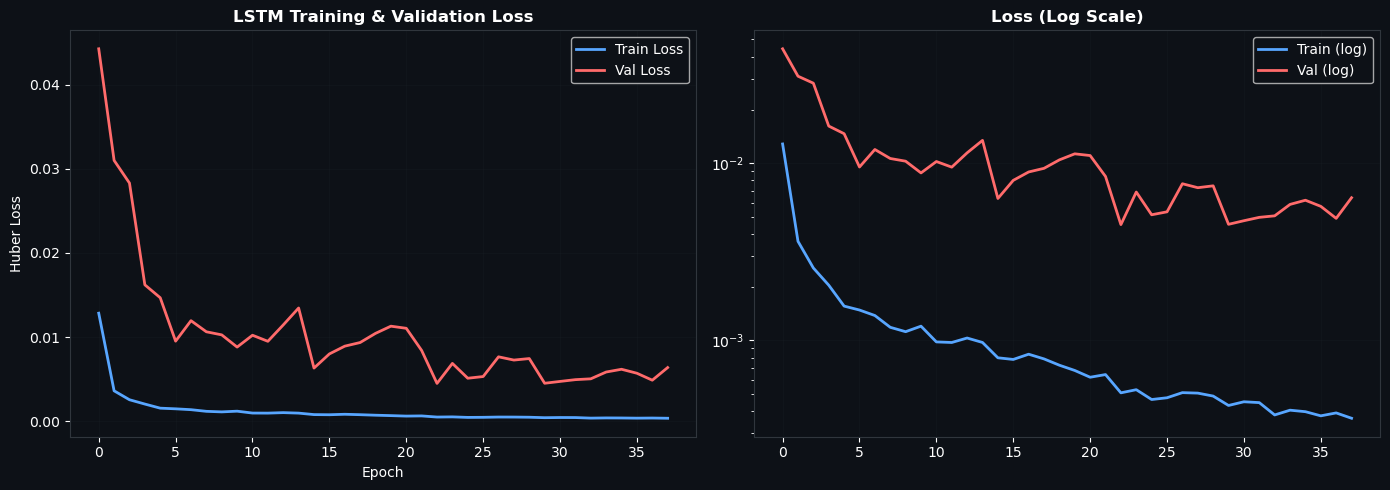

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step

🧠 LSTM Results:
   MAE  : $34.71
   RMSE : $35.32
   MAPE : 12.87%
   R²   : -12.1602


In [18]:
# ─── LSTM Training Curves ─────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.patch.set_facecolor('#0d1117')

for ax, metric, title in zip(axes,
    [history.history['loss'], history.history['val_loss']],
    ['Training Loss', 'Validation Loss']):
    pass

ax1, ax2 = axes
ax1.set_facecolor('#0d1117')
ax1.plot(history.history['loss'], color='#58a6ff', lw=2, label='Train Loss')
ax1.plot(history.history['val_loss'], color='#ff6b6b', lw=2, label='Val Loss')
ax1.set_title('LSTM Training & Validation Loss', color='white', fontweight='bold')
ax1.set_xlabel('Epoch', color='white')
ax1.set_ylabel('Huber Loss', color='white')
ax1.legend()
ax1.grid(True, alpha=0.2)
ax1.tick_params(colors='white')

# Log scale
ax2.set_facecolor('#0d1117')
ax2.semilogy(history.history['loss'], color='#58a6ff', lw=2, label='Train (log)')
ax2.semilogy(history.history['val_loss'], color='#ff6b6b', lw=2, label='Val (log)')
ax2.set_title('Loss (Log Scale)', color='white', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.2)
ax2.tick_params(colors='white')

plt.tight_layout()
plt.show()

# LSTM predictions
lstm_pred_scaled = lstm_model.predict(X_te_lstm)
lstm_pred = target_scaler.inverse_transform(lstm_pred_scaled).flatten()
lstm_actual = target_scaler.inverse_transform(y_te_lstm.reshape(-1, 1)).flatten()

lstm_mae  = mean_absolute_error(lstm_actual, lstm_pred)
lstm_rmse = np.sqrt(mean_squared_error(lstm_actual, lstm_pred))
lstm_r2   = r2_score(lstm_actual, lstm_pred)
lstm_mape = np.mean(np.abs((lstm_actual - lstm_pred) / lstm_actual)) * 100

print('\n🧠 LSTM Results:')
print(f'   MAE  : ${lstm_mae:.2f}')
print(f'   RMSE : ${lstm_rmse:.2f}')
print(f'   MAPE : {lstm_mape:.2f}%')
print(f'   R²   : {lstm_r2:.4f}')

---
## 🤝 Cell 16 — Ensemble Model (Weighted Average)

In [19]:
# ─── Ensemble: Inverse-RMSE Weighted Average ─────────────────────────────────
# Ensure all predictions align to the same test dates
# RF and XGB predictions are for X_test (n_test rows)
# LSTM prediction may differ by SEQUENCE_LEN offset - align here
n_lstm = len(lstm_pred)

rf_pred_aligned   = rf_pred[-n_lstm:]
xgb_pred_aligned  = xgb_pred[-n_lstm:]
actual_aligned    = y_test.values[-n_lstm:]
dates_aligned     = test_dates[-n_lstm:]

# Weights inversely proportional to RMSE on aligned
rmse_rf   = np.sqrt(mean_squared_error(actual_aligned, rf_pred_aligned))
rmse_xgb  = np.sqrt(mean_squared_error(actual_aligned, xgb_pred_aligned))
rmse_lstm = lstm_rmse

total_inv = 1/rmse_rf + 1/rmse_xgb + 1/rmse_lstm
w_rf   = (1/rmse_rf)   / total_inv
w_xgb  = (1/rmse_xgb)  / total_inv
w_lstm = (1/rmse_lstm)  / total_inv

ensemble_pred = w_rf*rf_pred_aligned + w_xgb*xgb_pred_aligned + w_lstm*lstm_pred

ens_mae  = mean_absolute_error(actual_aligned, ensemble_pred)
ens_rmse = np.sqrt(mean_squared_error(actual_aligned, ensemble_pred))
ens_r2   = r2_score(actual_aligned, ensemble_pred)
ens_mape = np.mean(np.abs((actual_aligned - ensemble_pred) / actual_aligned)) * 100

print(f'🤝 Ensemble Weights → RF: {w_rf:.2%}  |  XGB: {w_xgb:.2%}  |  LSTM: {w_lstm:.2%}')
print(f'\n🏆 Ensemble Results:')
print(f'   MAE  : ${ens_mae:.2f}')
print(f'   RMSE : ${ens_rmse:.2f}')
print(f'   MAPE : {ens_mape:.2f}%')
print(f'   R²   : {ens_r2:.4f}')

🤝 Ensemble Weights → RF: 72.51%  |  XGB: 17.50%  |  LSTM: 9.99%

🏆 Ensemble Results:
   MAE  : $7.73
   RMSE : $9.24
   MAPE : 2.82%
   R²   : 0.1001


---
## 📊 Cell 17 — Model Comparison Dashboard

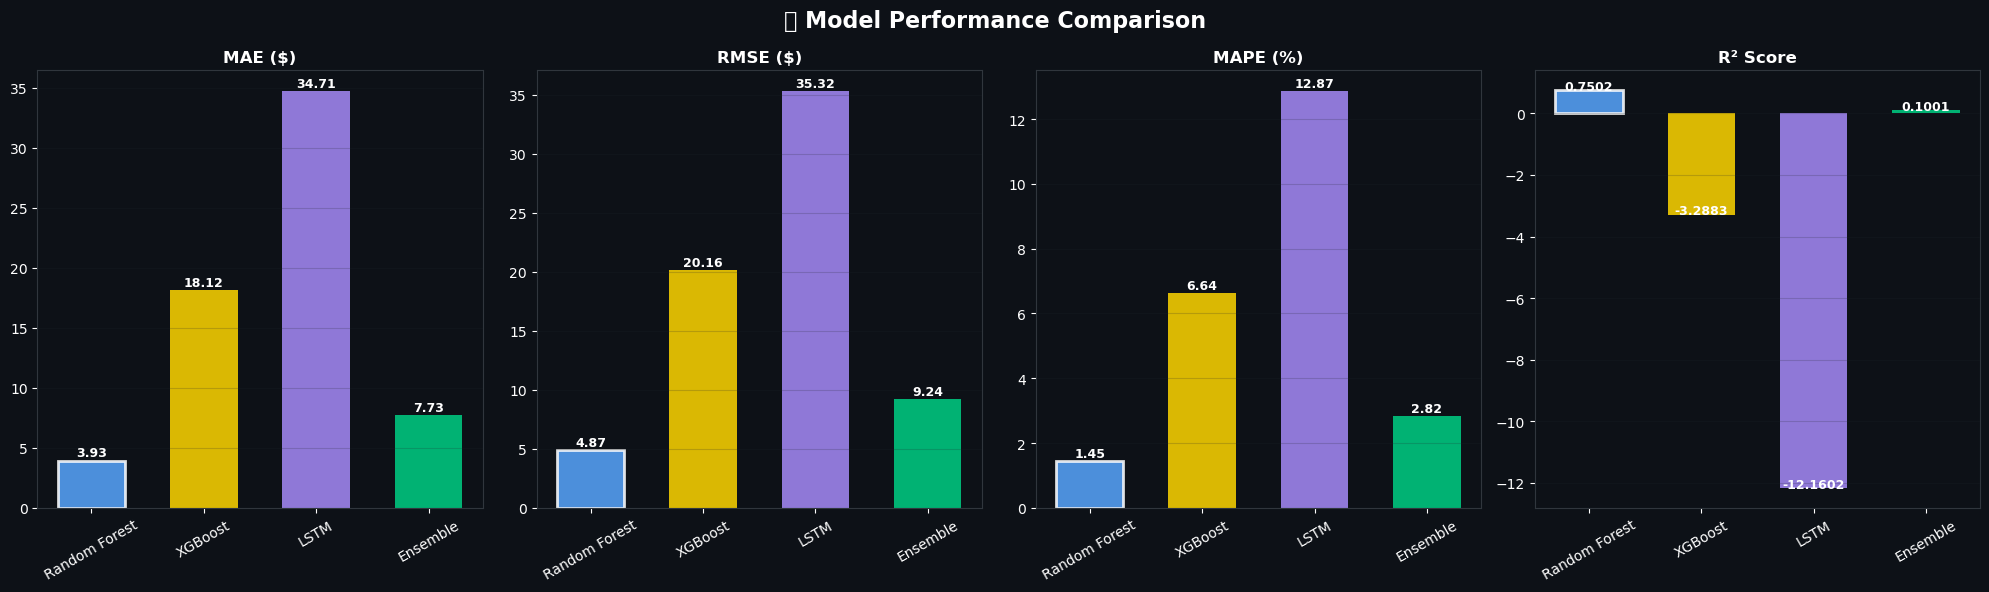


📋 Performance Summary:
               MAE ($)  RMSE ($)  MAPE (%)  R² Score
Random Forest   3.9274    4.8659    1.4513    0.7502
XGBoost        18.1228   20.1619    6.6378   -3.2883
LSTM           34.7135   35.3198   12.8658  -12.1602
Ensemble        7.7308    9.2358    2.8194    0.1001


In [20]:
# ─── Side-by-side Model Comparison ───────────────────────────────────────────
models = ['Random Forest', 'XGBoost', 'LSTM', 'Ensemble']
metrics_dict = {
    'MAE ($)' : [rf_mae, xgb_mae, lstm_mae, ens_mae],
    'RMSE ($)': [rmse_rf, rmse_xgb, rmse_lstm, ens_rmse],
    'MAPE (%)': [rf_mape, xgb_mape, lstm_mape, ens_mape],
    'R² Score': [rf_r2, xgb_r2, lstm_r2, ens_r2],
}

fig, axes = plt.subplots(1, 4, figsize=(20, 6))
fig.patch.set_facecolor('#0d1117')
fig.suptitle('📊 Model Performance Comparison', fontsize=16, fontweight='bold', color='white')

bar_colors = ['#58a6ff', '#ffd700', '#a78bfa', '#00d084']

for ax, (metric, vals) in zip(axes, metrics_dict.items()):
    ax.set_facecolor('#0d1117')
    is_r2 = 'R²' in metric
    bars = ax.bar(models, vals, color=bar_colors, alpha=0.85, edgecolor='none', width=0.6)
    best_idx = np.argmax(vals) if is_r2 else np.argmin(vals)
    bars[best_idx].set_edgecolor('white')
    bars[best_idx].set_linewidth(2)
    ax.set_title(metric, color='white', fontweight='bold', fontsize=12)
    ax.tick_params(colors='white', axis='both')
    ax.tick_params(axis='x', rotation=30)
    ax.grid(True, alpha=0.2, axis='y')
    for bar, val in zip(bars, vals):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(vals)*0.01,
                f'{val:.4f}' if is_r2 else f'{val:.2f}',
                ha='center', fontsize=9, color='white', fontweight='bold')

plt.tight_layout()
plt.show()

# Print comparison table
results_df = pd.DataFrame(metrics_dict, index=models).round(4)
print('\n📋 Performance Summary:')
print(results_df.to_string())

---
## 🎯 Cell 18 — Predicted vs. Actual (Main Results Chart)

In [21]:
# ─── Predicted vs Actual — Interactive Plotly ─────────────────────────────────
fig = go.Figure()

# Actual
fig.add_trace(go.Scatter(
    x=dates_aligned, y=actual_aligned,
    name='📍 Actual Close Price',
    line=dict(color='white', width=2.5),
    mode='lines'
))

# RF
fig.add_trace(go.Scatter(
    x=dates_aligned, y=rf_pred_aligned,
    name='🌲 Random Forest',
    line=dict(color='#58a6ff', width=1.5, dash='dot'),
))

# XGB
fig.add_trace(go.Scatter(
    x=dates_aligned, y=xgb_pred_aligned,
    name='⚡ XGBoost',
    line=dict(color='#ffd700', width=1.5, dash='dot'),
))

# LSTM
fig.add_trace(go.Scatter(
    x=dates_aligned, y=lstm_pred,
    name='🧠 LSTM',
    line=dict(color='#a78bfa', width=1.5, dash='dot'),
))

# Ensemble
fig.add_trace(go.Scatter(
    x=dates_aligned, y=ensemble_pred,
    name='🏆 Ensemble (Best)',
    line=dict(color='#00d084', width=2.5),
))

fig.update_layout(
    template='plotly_dark',
    title='AAPL — Predicted vs. Actual Closing Price (Test Period)',
    xaxis_title='Date',
    yaxis_title='Price (USD)',
    height=550,
    legend=dict(orientation='h', y=-0.15),
    hovermode='x unified'
)
fig.show()

---
## 📏 Cell 19 — Residual & Error Analysis

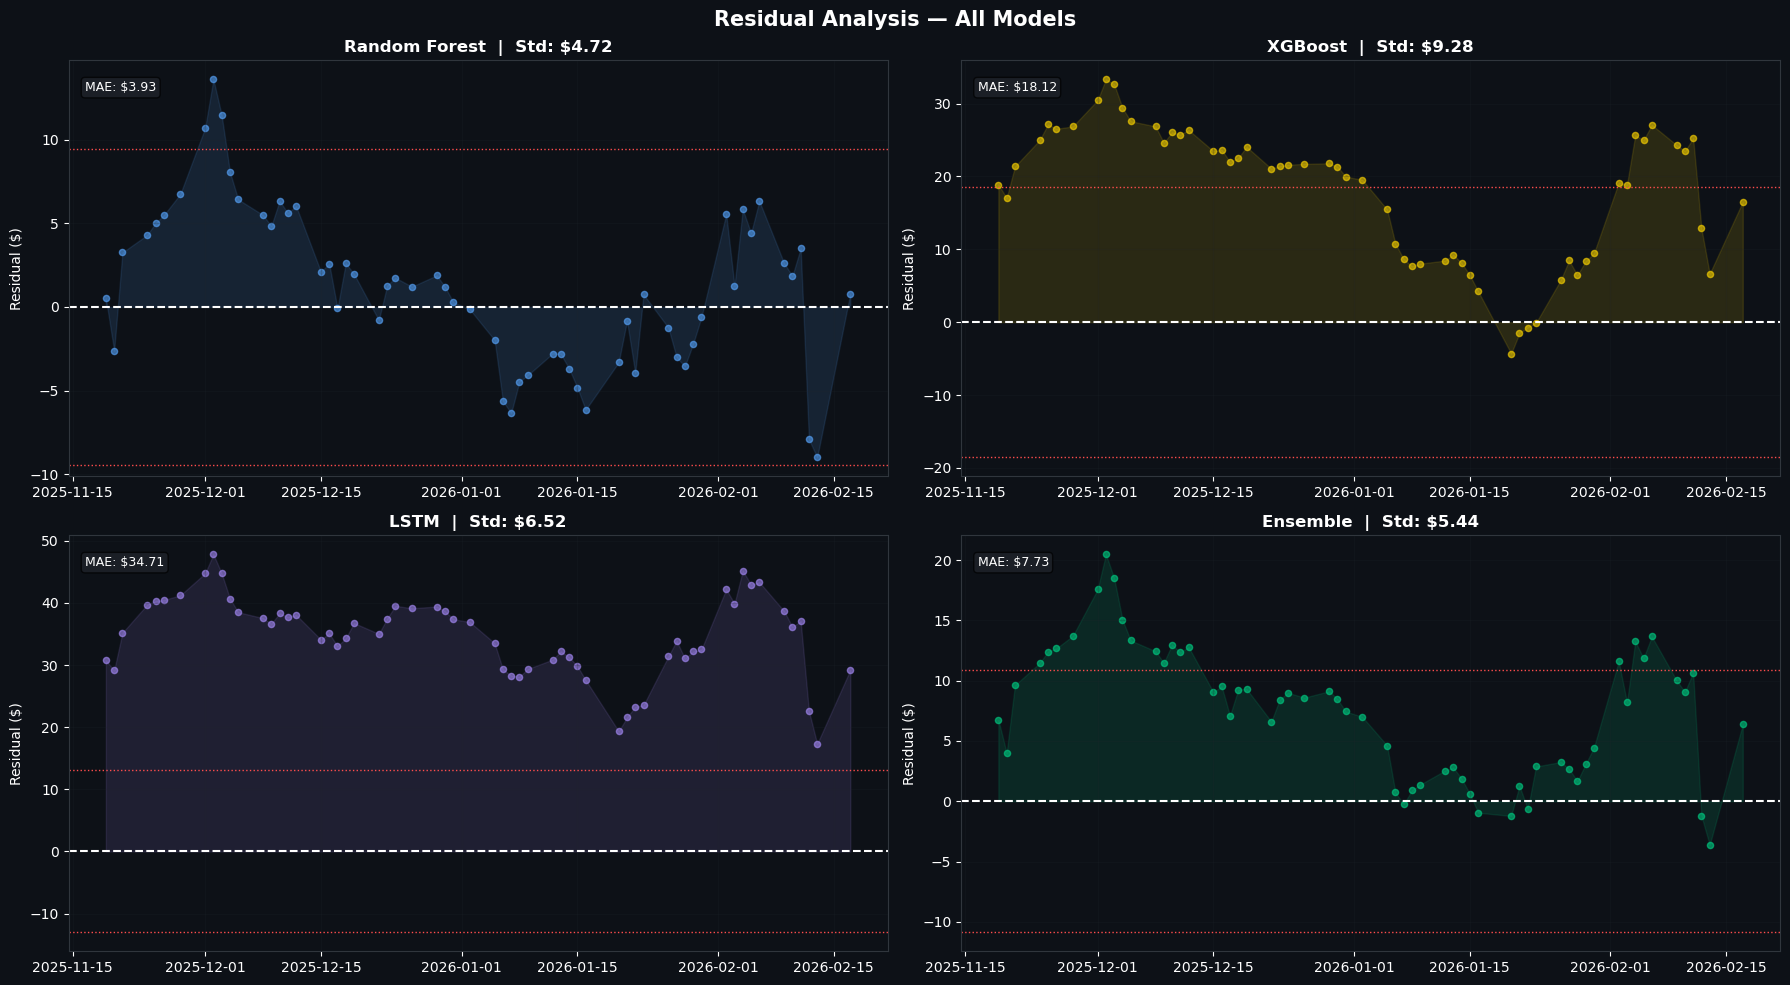

In [22]:
# ─── Residual Analysis ────────────────────────────────────────────────────────
residuals_rf  = actual_aligned - rf_pred_aligned
residuals_xgb = actual_aligned - xgb_pred_aligned
residuals_lstm= actual_aligned - lstm_pred
residuals_ens = actual_aligned - ensemble_pred

fig, axes = plt.subplots(2, 2, figsize=(18, 10))
fig.patch.set_facecolor('#0d1117')
fig.suptitle('Residual Analysis — All Models', fontsize=15, fontweight='bold', color='white')

configs = [
    ('Random Forest', residuals_rf, '#58a6ff', axes[0,0]),
    ('XGBoost',       residuals_xgb, '#ffd700', axes[0,1]),
    ('LSTM',          residuals_lstm, '#a78bfa', axes[1,0]),
    ('Ensemble',      residuals_ens,  '#00d084', axes[1,1]),
]

for name, res, color, ax in configs:
    ax.set_facecolor('#0d1117')
    ax.scatter(dates_aligned, res, color=color, alpha=0.6, s=20)
    ax.axhline(0, color='white', lw=1.5, linestyle='--')
    ax.fill_between(dates_aligned, res, alpha=0.12, color=color)
    std = np.std(res)
    ax.axhline(2*std,  color='#ff4d4d', lw=1, linestyle=':')
    ax.axhline(-2*std, color='#ff4d4d', lw=1, linestyle=':')
    ax.set_title(f'{name}  |  Std: ${std:.2f}', color='white', fontweight='bold')
    ax.set_ylabel('Residual ($)', color='white')
    ax.grid(True, alpha=0.2)
    ax.tick_params(colors='white')
    # Add text annotations
    ax.text(0.02, 0.95, f'MAE: ${np.mean(np.abs(res)):.2f}', transform=ax.transAxes,
            color='white', fontsize=9, va='top',
            bbox=dict(boxstyle='round', facecolor='#21262d', alpha=0.7))

plt.tight_layout()
plt.show()

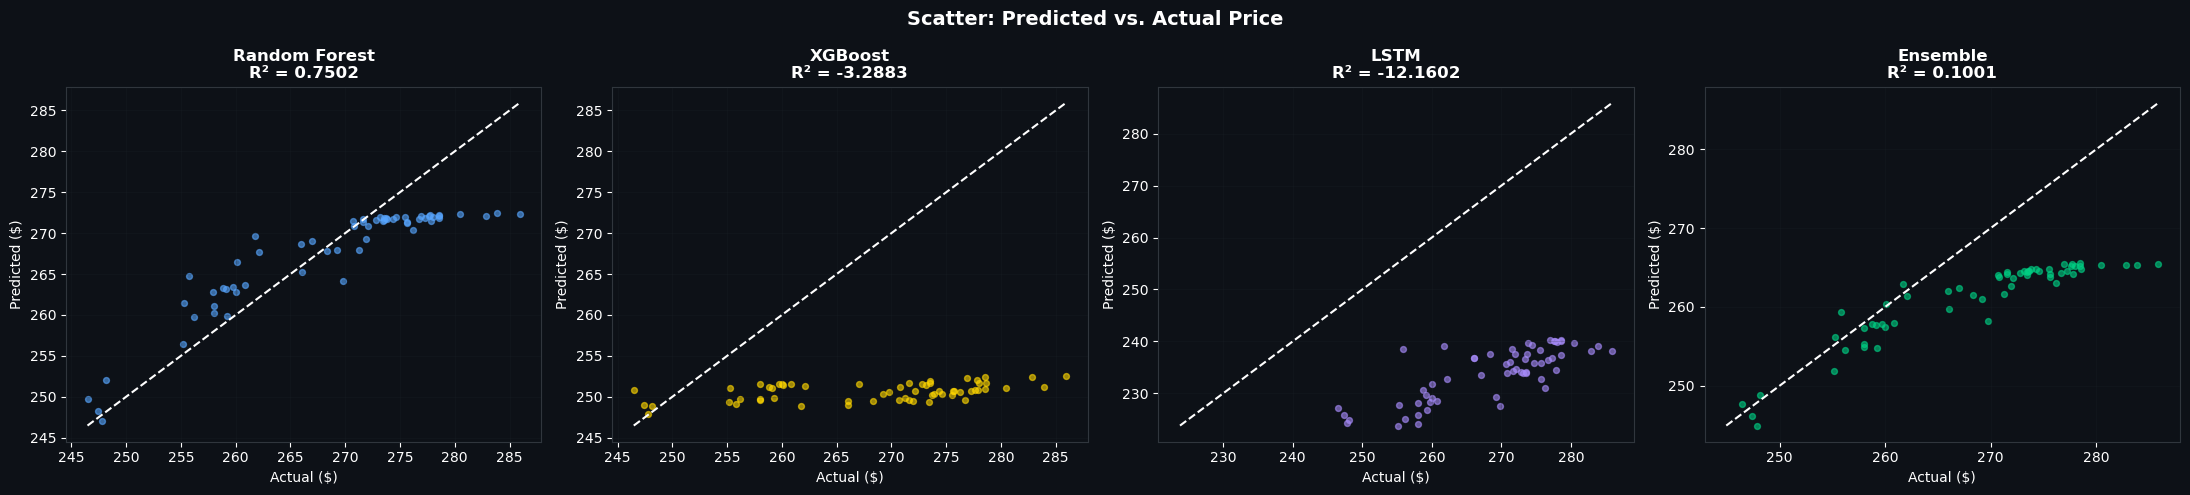

In [23]:
# ─── Scatter: Predicted vs Actual ─────────────────────────────────────────────
fig, axes = plt.subplots(1, 4, figsize=(22, 5))
fig.patch.set_facecolor('#0d1117')
fig.suptitle('Scatter: Predicted vs. Actual Price', fontsize=14, fontweight='bold', color='white')

for ax, (name, pred, color) in zip(axes, [
    ('Random Forest', rf_pred_aligned, '#58a6ff'),
    ('XGBoost',       xgb_pred_aligned,'#ffd700'),
    ('LSTM',          lstm_pred,       '#a78bfa'),
    ('Ensemble',      ensemble_pred,   '#00d084'),
]):
    ax.set_facecolor('#0d1117')
    ax.scatter(actual_aligned, pred, color=color, alpha=0.6, s=18)
    min_val = min(actual_aligned.min(), pred.min())
    max_val = max(actual_aligned.max(), pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'w--', lw=1.5, label='Perfect fit')
    ax.set_xlabel('Actual ($)', color='white')
    ax.set_ylabel('Predicted ($)', color='white')
    ax.set_title(f'{name}\nR² = {r2_score(actual_aligned, pred):.4f}', color='white', fontweight='bold')
    ax.grid(True, alpha=0.2)
    ax.tick_params(colors='white')

plt.tight_layout()
plt.show()

---
## 🌟 Cell 20 — Feature Importance

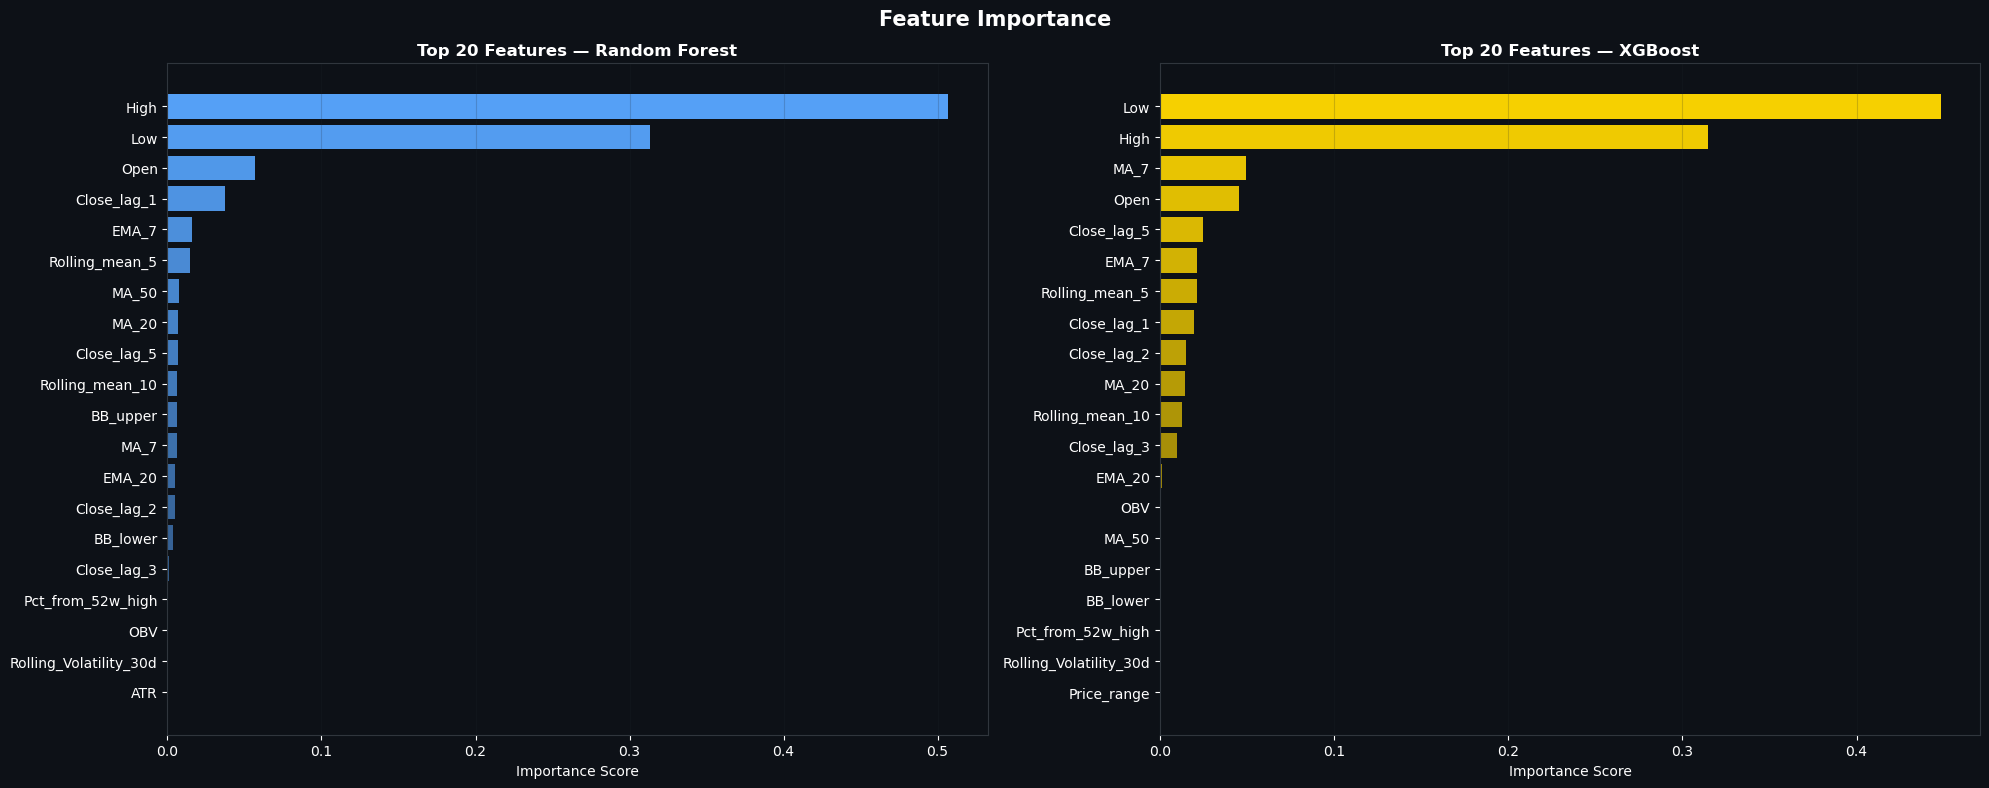

In [24]:
# ─── Feature Importance (RF + XGB) ───────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.patch.set_facecolor('#0d1117')
fig.suptitle('Feature Importance', fontsize=15, fontweight='bold', color='white')

for ax, model, name, color in [
    (axes[0], rf_model,  'Random Forest', '#58a6ff'),
    (axes[1], xgb_model, 'XGBoost',       '#ffd700'),
]:
    ax.set_facecolor('#0d1117')
    importances = pd.Series(model.feature_importances_, index=FEATURE_COLS)
    top20 = importances.nlargest(20).sort_values()
    bars = ax.barh(top20.index, top20.values, color=color, alpha=0.8, edgecolor='none')
    # Color gradient
    for i, bar in enumerate(bars):
        bar.set_alpha(0.4 + 0.6 * (i / len(bars)))
    ax.set_title(f'Top 20 Features — {name}', color='white', fontweight='bold')
    ax.set_xlabel('Importance Score', color='white')
    ax.tick_params(colors='white')
    ax.grid(True, alpha=0.2, axis='x')

plt.tight_layout()
plt.show()

---
## 🔮 Cell 21 — Predict Tomorrow's Closing Price

In [25]:
# ─── Predict Next Day's Price ─────────────────────────────────────────────────
# Latest available data row for ML models
latest_features = ml_df[FEATURE_COLS].iloc[-1].values.reshape(1, -1)

rf_tomorrow  = rf_model.predict(latest_features)[0]
xgb_tomorrow = xgb_model.predict(latest_features)[0]

# LSTM: use last SEQUENCE_LEN rows
latest_seq_raw = ml_df[FEATURE_COLS].iloc[-SEQUENCE_LEN:].values
latest_seq_scaled = feature_scaler.transform(latest_seq_raw).reshape(1, SEQUENCE_LEN, len(FEATURE_COLS))
lstm_tomorrow_scaled = lstm_model.predict(latest_seq_scaled)
lstm_tomorrow = target_scaler.inverse_transform(lstm_tomorrow_scaled)[0][0]

# Ensemble
ens_tomorrow = w_rf*rf_tomorrow + w_xgb*xgb_tomorrow + w_lstm*lstm_tomorrow

today_close  = df['Close'].iloc[-1]
today_date   = df.index[-1].date()

print('═' * 55)
print('  🍎 APPLE (AAPL) — NEXT DAY PREDICTION REPORT')
print('═' * 55)
print(f'  Last Close : ${today_close:.2f} on {today_date}')
print('─' * 55)
print(f'  🌲 Random Forest  → ${rf_tomorrow:.2f}  ({(rf_tomorrow/today_close-1)*100:+.2f}%)')
print(f'  ⚡ XGBoost        → ${xgb_tomorrow:.2f}  ({(xgb_tomorrow/today_close-1)*100:+.2f}%)')
print(f'  🧠 LSTM           → ${lstm_tomorrow:.2f}  ({(lstm_tomorrow/today_close-1)*100:+.2f}%)')
print('─' * 55)
print(f'  🏆 ENSEMBLE (Best)→ ${ens_tomorrow:.2f}  ({(ens_tomorrow/today_close-1)*100:+.2f}%)')
print('═' * 55)

direction = '📈 UP' if ens_tomorrow > today_close else '📉 DOWN'
print(f'\n  Predicted direction: {direction}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
═══════════════════════════════════════════════════════
  🍎 APPLE (AAPL) — NEXT DAY PREDICTION REPORT
═══════════════════════════════════════════════════════
  Last Close : $266.07 on 2026-02-17
───────────────────────────────────────────────────────
  🌲 Random Forest  → $265.28  (-0.30%)
  ⚡ XGBoost        → $249.53  (-6.21%)
  🧠 LSTM           → $236.26  (-11.20%)
───────────────────────────────────────────────────────
  🏆 ENSEMBLE (Best)→ $259.62  (-2.42%)
═══════════════════════════════════════════════════════

  Predicted direction: 📉 DOWN


---
## 🎨 Cell 22 — Final Summary Dashboard

In [26]:
# ─── Full Final Dashboard ─────────────────────────────────────────────────────
fig = make_subplots(
    rows=3, cols=2,
    subplot_titles=[
        '📈 AAPL Historical Price',
        '📊 Model MAPE Comparison (%)',
        '🎯 Ensemble: Predicted vs Actual (Test)',
        '📉 Prediction Error Over Time',
        '🌡️ RSI Signal',
        '💡 Next-Day Forecast'
    ],
    vertical_spacing=0.12,
    horizontal_spacing=0.08
)

# 1. Full price history
fig.add_trace(go.Scatter(x=df.index, y=df['Close'], line=dict(color='#58a6ff', width=1),
                         fill='tozeroy', fillcolor='rgba(88,166,255,0.07)', name='Close'), row=1, col=1)

# 2. MAPE bar
mape_vals = [rf_mape, xgb_mape, lstm_mape, ens_mape]
mape_names = ['RF', 'XGB', 'LSTM', 'Ensemble']
fig.add_trace(go.Bar(x=mape_names, y=mape_vals,
                     marker_color=['#58a6ff','#ffd700','#a78bfa','#00d084'],
                     text=[f'{v:.2f}%' for v in mape_vals], textposition='outside',
                     name='MAPE'), row=1, col=2)

# 3. Ensemble pred vs actual
fig.add_trace(go.Scatter(x=dates_aligned, y=actual_aligned, name='Actual',
                         line=dict(color='white', width=2)), row=2, col=1)
fig.add_trace(go.Scatter(x=dates_aligned, y=ensemble_pred, name='Ensemble Pred',
                         line=dict(color='#00d084', width=2, dash='dot')), row=2, col=1)

# 4. Error over time
pct_error = (ensemble_pred - actual_aligned) / actual_aligned * 100
err_colors = ['#00d084' if e >= 0 else '#ff4d4d' for e in pct_error]
fig.add_trace(go.Bar(x=dates_aligned, y=pct_error,
                     marker_color=err_colors, name='Error %'), row=2, col=2)

# 5. RSI
plot_rsi = df['RSI'].last('180D')
fig.add_trace(go.Scatter(x=plot_rsi.index, y=plot_rsi,
                         line=dict(color='#a78bfa', width=1.5), name='RSI'), row=3, col=1)
fig.add_hline(y=70, line_dash='dash', line_color='#ff4d4d', row=3, col=1)
fig.add_hline(y=30, line_dash='dash', line_color='#00d084', row=3, col=1)

# 6. Next-day forecast bar
fig.add_trace(go.Bar(
    x=['Yesterday', 'RF', 'XGB', 'LSTM', 'Ensemble'],
    y=[today_close, rf_tomorrow, xgb_tomorrow, lstm_tomorrow, ens_tomorrow],
    marker_color=['white','#58a6ff','#ffd700','#a78bfa','#00d084'],
    text=[f'${v:.2f}' for v in [today_close, rf_tomorrow, xgb_tomorrow, lstm_tomorrow, ens_tomorrow]],
    textposition='outside',
    name='Forecast'
), row=3, col=2)

fig.update_layout(
    template='plotly_dark',
    height=950,
    title_text='🍎 AAPL Stock Forecasting — Full Summary Dashboard',
    title_font_size=18,
    showlegend=False
)
fig.show()

---
## ✅ Cell 23 — Conclusion

In [27]:
# ─── Final Summary Report ─────────────────────────────────────────────────────
best_model_idx = np.argmin([rf_mape, xgb_mape, lstm_mape, ens_mape])
best_model_name = ['Random Forest', 'XGBoost', 'LSTM', 'Ensemble'][best_model_idx]
best_mape = min(rf_mape, xgb_mape, lstm_mape, ens_mape)

print('='*60)
print('  📋 INTERNAL ASSESSMENT — FINAL REPORT SUMMARY')
print('='*60)
print(f'  Stock         : Apple Inc. (AAPL)')
print(f'  Data Range    : {df.index[0].date()} → {df.index[-1].date()}')
print(f'  Features Used : {len(FEATURE_COLS)}')
print(f'  Models Tested : Random Forest, XGBoost, LSTM, Ensemble')
print()
print('  ── Model Performance (Test Set) ──')
print(f'  Model          MAE($)  RMSE($)  MAPE(%)   R²')
print(f'  Random Forest  {rf_mae:.2f}   {rmse_rf:.2f}    {rf_mape:.2f}%   {rf_r2:.4f}')
print(f'  XGBoost        {xgb_mae:.2f}   {rmse_xgb:.2f}    {xgb_mape:.2f}%   {xgb_r2:.4f}')
print(f'  LSTM           {lstm_mae:.2f}   {rmse_lstm:.2f}    {lstm_mape:.2f}%   {lstm_r2:.4f}')
print(f'  Ensemble       {ens_mae:.2f}   {ens_rmse:.2f}    {ens_mape:.2f}%   {ens_r2:.4f}')
print()
print(f'  🏆 Best Model   : {best_model_name} (MAPE: {best_mape:.2f}%)')
print()
print(f'  ── Next Trading Day Forecast ──')
print(f'  Last Close     : ${today_close:.2f} ({today_date})')
print(f'  Ensemble Pred  : ${ens_tomorrow:.2f}  ({(ens_tomorrow/today_close-1)*100:+.2f}%)')
print('='*60)

  📋 INTERNAL ASSESSMENT — FINAL REPORT SUMMARY
  Stock         : Apple Inc. (AAPL)
  Data Range    : 2018-01-02 → 2026-02-17
  Features Used : 37
  Models Tested : Random Forest, XGBoost, LSTM, Ensemble

  ── Model Performance (Test Set) ──
  Model          MAE($)  RMSE($)  MAPE(%)   R²
  Random Forest  3.93   4.87    1.45%   0.7502
  XGBoost        18.12   20.16    6.64%   -3.2883
  LSTM           34.71   35.32    12.87%   -12.1602
  Ensemble       7.73   9.24    2.82%   0.1001

  🏆 Best Model   : Random Forest (MAPE: 1.45%)

  ── Next Trading Day Forecast ──
  Last Close     : $266.07 (2026-02-17)
  Ensemble Pred  : $259.62  (-2.42%)


In [28]:
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from datetime import datetime, timedelta

# ─── Re-fetch to make sure we have today's data ───────────────────────────────
fresh = yf.download('AAPL', period='5d', auto_adjust=True, progress=False)
fresh.columns = fresh.columns.droplevel(1) if isinstance(fresh.columns, pd.MultiIndex) else fresh.columns
fresh.index   = pd.to_datetime(fresh.index)

# ─── Identify yesterday & today ───────────────────────────────────────────────
today_date     = fresh.index[-1].date()
yesterday_date = fresh.index[-2].date()

today_actual_close     = float(fresh['Close'].iloc[-1])
yesterday_actual_close = float(fresh['Close'].iloc[-2])

print(f'📅 Yesterday : {yesterday_date}  →  Close: ${yesterday_actual_close:.2f}')
print(f'📅 Today     : {today_date}      →  Actual Close: ${today_actual_close:.2f}')
print(f'📊 Day change: {(today_actual_close/yesterday_actual_close - 1)*100:+.2f}%')

📅 Yesterday : 2026-02-13  →  Close: $255.78
📅 Today     : 2026-02-17      →  Actual Close: $265.42
📊 Day change: +3.77%


In [29]:
# ─── The ml_df already has all engineered features ────────────────────────────
# Yesterday's row = second-to-last row in ml_df
# (last row = today, second-to-last = yesterday)

# Check if today is already in ml_df (market closed) or not (still open)
if ml_df.index[-1].date() == today_date:
    # Today's data is in → use yesterday's row (index -2) as input
    input_row_idx = -2
    print(f'✅ Today ({today_date}) is in dataset. Using yesterday ({yesterday_date}) as input.')
else:
    # Today not yet in → use last available row (yesterday) as input
    input_row_idx = -1
    print(f'✅ Market may still be open. Last available row ({ml_df.index[-1].date()}) used as input.')

# ─── Extract yesterday's features ────────────────────────────────────────────
yesterday_features = ml_df[FEATURE_COLS].iloc[input_row_idx].values.reshape(1, -1)

# ─── ML model predictions (RF + XGB) ─────────────────────────────────────────
pred_rf_today  = float(rf_model.predict(yesterday_features)[0])
pred_xgb_today = float(xgb_model.predict(yesterday_features)[0])

# ─── LSTM: needs a sequence of SEQUENCE_LEN days ending at yesterday ──────────
end_idx   = input_row_idx if input_row_idx == -2 else len(ml_df)
start_idx = end_idx - SEQUENCE_LEN

lstm_seq_raw    = ml_df[FEATURE_COLS].iloc[start_idx:end_idx].values
lstm_seq_scaled = feature_scaler.transform(lstm_seq_raw).reshape(1, SEQUENCE_LEN, len(FEATURE_COLS))
lstm_pred_scaled_today = lstm_model.predict(lstm_seq_scaled, verbose=0)
pred_lstm_today = float(target_scaler.inverse_transform(lstm_pred_scaled_today)[0][0])

# ─── Ensemble ─────────────────────────────────────────────────────────────────
pred_ens_today = w_rf * pred_rf_today + w_xgb * pred_xgb_today + w_lstm * pred_lstm_today

# ─── Compute errors vs today's actual ────────────────────────────────────────
def pct_err(pred, actual):
    return (pred - actual) / actual * 100

print()
print('═' * 62)
print('   🍎 AAPL — TODAY\'s CLOSING PRICE PREDICTION')
print('═' * 62)
print(f'   Input (Yesterday Close) : ${yesterday_actual_close:.2f}  [{yesterday_date}]')
print(f'   Actual Today Close      : ${today_actual_close:.2f}  [{today_date}]')
print('─' * 62)
print(f'   {"Model":<18} {"Predicted":>10} {"Error ($)":>12} {"Error (%)":>12}')
print('─' * 62)
for name, pred in [
    ('🌲 Random Forest',  pred_rf_today),
    ('⚡ XGBoost',        pred_xgb_today),
    ('🧠 LSTM',           pred_lstm_today),
    ('🏆 Ensemble',       pred_ens_today),
]:
    err_dollar = pred - today_actual_close
    err_pct    = pct_err(pred, today_actual_close)
    marker = ' ← BEST' if name == '🏆 Ensemble' else ''
    print(f'   {name:<20} ${pred:>8.2f}   {err_dollar:>+9.2f}   {err_pct:>+9.2f}%{marker}')
print('═' * 62)

✅ Today (2026-02-17) is in dataset. Using yesterday (2026-02-13) as input.

══════════════════════════════════════════════════════════════
   🍎 AAPL — TODAY's CLOSING PRICE PREDICTION
══════════════════════════════════════════════════════════════
   Input (Yesterday Close) : $255.78  [2026-02-13]
   Actual Today Close      : $265.42  [2026-02-17]
──────────────────────────────────────────────────────────────
   Model               Predicted    Error ($)    Error (%)
──────────────────────────────────────────────────────────────
   🌲 Random Forest      $  264.77       -0.65       -0.25%
   ⚡ XGBoost            $  249.13      -16.29       -6.14%
   🧠 LSTM               $  238.46      -26.96      -10.16%
   🏆 Ensemble           $  259.40       -6.02       -2.27% ← BEST
══════════════════════════════════════════════════════════════


In [30]:
# ─── Plotly: Today's Prediction vs Actual ─────────────────────────────────────
model_names = ['Random\nForest', 'XGBoost', 'LSTM', 'Ensemble']
preds_today = [pred_rf_today, pred_xgb_today, pred_lstm_today, pred_ens_today]
colors_bar  = ['#58a6ff', '#ffd700', '#a78bfa', '#00d084']
errors_pct  = [pct_err(p, today_actual_close) for p in preds_today]

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=[
        f'Predicted vs Actual Close — {today_date}',
        'Prediction Error (%) per Model'
    ],
    column_widths=[0.55, 0.45]
)

# ── Left: Bar chart with actual line ──
fig.add_trace(go.Bar(
    x=['RF', 'XGB', 'LSTM', 'Ensemble'],
    y=preds_today,
    marker_color=colors_bar,
    opacity=0.85,
    name='Predicted',
    text=[f'${p:.2f}' for p in preds_today],
    textposition='outside',
    textfont=dict(color='white', size=12)
), row=1, col=1)

# Actual close as a horizontal line
fig.add_hline(
    y=today_actual_close,
    line_dash='dash', line_color='white', line_width=2.5,
    annotation_text=f'Actual: ${today_actual_close:.2f}',
    annotation_font_color='white',
    annotation_position='top left',
    row=1, col=1
)

# ── Right: Error % bars ──
err_colors = ['#00d084' if e >= 0 else '#ff4d4d' for e in errors_pct]
fig.add_trace(go.Bar(
    x=['RF', 'XGB', 'LSTM', 'Ensemble'],
    y=errors_pct,
    marker_color=err_colors,
    opacity=0.85,
    name='Error %',
    text=[f'{e:+.2f}%' for e in errors_pct],
    textposition='outside',
    textfont=dict(color='white', size=12)
), row=1, col=2)

fig.add_hline(y=0, line_color='white', line_width=1, row=1, col=2)

fig.update_layout(
    template='plotly_dark',
    height=480,
    title=f'🍎 AAPL — Today\'s Price Prediction Report ({today_date})',
    showlegend=False,
    yaxis=dict(range=[min(preds_today + [today_actual_close]) * 0.99,
                      max(preds_today + [today_actual_close]) * 1.02])
)
fig.show()

In [31]:
# ─── Roll-forward prediction: for each day in test set, predict using previous day ─
# This gives us a realistic "yesterday → today" curve for all 60 test days

rolling_rf   = []
rolling_xgb  = []
rolling_lstm = []
rolling_ens  = []
rolling_actual = []
rolling_dates  = []

# We predict day i using features from day i-1
test_indices = list(range(len(ml_df) - n_test, len(ml_df)))

for i in test_indices:
    # Input: features from PREVIOUS day (i-1)
    prev_features = ml_df[FEATURE_COLS].iloc[i-1].values.reshape(1, -1)

    # RF and XGB
    p_rf  = float(rf_model.predict(prev_features)[0])
    p_xgb = float(xgb_model.predict(prev_features)[0])

    # LSTM: sequence ending at day i-1
    lstm_input_raw    = ml_df[FEATURE_COLS].iloc[i-SEQUENCE_LEN:i].values
    lstm_input_scaled = feature_scaler.transform(lstm_input_raw).reshape(1, SEQUENCE_LEN, len(FEATURE_COLS))
    lstm_out = lstm_model.predict(lstm_input_scaled, verbose=0)
    p_lstm   = float(target_scaler.inverse_transform(lstm_out)[0][0])

    p_ens = w_rf * p_rf + w_xgb * p_xgb + w_lstm * p_lstm

    rolling_rf.append(p_rf)
    rolling_xgb.append(p_xgb)
    rolling_lstm.append(p_lstm)
    rolling_ens.append(p_ens)
    rolling_actual.append(float(ml_df[TARGET].iloc[i]))
    rolling_dates.append(ml_df.index[i])

print(f'✅ Roll-forward predictions computed for {len(rolling_dates)} trading days')
print(f'   From: {rolling_dates[0].date()} → {rolling_dates[-1].date()}')

✅ Roll-forward predictions computed for 60 trading days
   From: 2025-11-19 → 2026-02-17


In [32]:
# ─── Interactive Comparison Chart: All Models vs Actual ───────────────────────
fig = go.Figure()

# Shaded confidence zone (±2% around ensemble)
upper_band = [p * 1.02 for p in rolling_ens]
lower_band = [p * 0.98 for p in rolling_ens]

fig.add_trace(go.Scatter(
    x=rolling_dates + rolling_dates[::-1],
    y=upper_band + lower_band[::-1],
    fill='toself',
    fillcolor='rgba(0, 208, 132, 0.08)',
    line=dict(color='rgba(0,0,0,0)'),
    hoverinfo='skip',
    name='±2% Band'
))

# Actual
fig.add_trace(go.Scatter(
    x=rolling_dates, y=rolling_actual,
    name='📍 Actual Close',
    line=dict(color='white', width=3),
    mode='lines+markers',
    marker=dict(size=4, color='white')
))

# RF
fig.add_trace(go.Scatter(
    x=rolling_dates, y=rolling_rf,
    name='🌲 Random Forest',
    line=dict(color='#58a6ff', width=1.5, dash='dot'),
    opacity=0.85
))

# XGB
fig.add_trace(go.Scatter(
    x=rolling_dates, y=rolling_xgb,
    name='⚡ XGBoost',
    line=dict(color='#ffd700', width=1.5, dash='dot'),
    opacity=0.85
))

# LSTM
fig.add_trace(go.Scatter(
    x=rolling_dates, y=rolling_lstm,
    name='🧠 LSTM',
    line=dict(color='#a78bfa', width=1.5, dash='dot'),
    opacity=0.85
))

# Ensemble
fig.add_trace(go.Scatter(
    x=rolling_dates, y=rolling_ens,
    name='🏆 Ensemble',
    line=dict(color='#00d084', width=2.5),
))

# Today's prediction marker
fig.add_trace(go.Scatter(
    x=[rolling_dates[-1]],
    y=[pred_ens_today],
    mode='markers+text',
    marker=dict(size=14, color='#00d084', symbol='star', line=dict(color='white', width=1.5)),
    text=[f'Today Pred: ${pred_ens_today:.2f}'],
    textposition='top center',
    textfont=dict(color='white', size=11),
    name=f'Today Pred (${pred_ens_today:.2f})'
))

fig.update_layout(
    template='plotly_dark',
    title=dict(
        text='🍎 AAPL — "Yesterday → Today" Roll-Forward Predictions vs Actual Close<br><sup>Each point: predicted using PREVIOUS day\'s features</sup>',
        font=dict(size=16)
    ),
    xaxis_title='Date',
    yaxis_title='Price (USD)',
    height=580,
    hovermode='x unified',
    legend=dict(orientation='h', y=-0.18, x=0.5, xanchor='center'),
)
fig.show()

In [37]:
# ─── Error timeline per model ─────────────────────────────────────────────────
err_rf   = [(p - a) / a * 100 for p, a in zip(rolling_rf,   rolling_actual)]
err_xgb  = [(p - a) / a * 100 for p, a in zip(rolling_xgb,  rolling_actual)]
err_lstm = [(p - a) / a * 100 for p, a in zip(rolling_lstm, rolling_actual)]
err_ens  = [(p - a) / a * 100 for p, a in zip(rolling_ens,  rolling_actual)]

fig = make_subplots(rows=4, cols=1, shared_xaxes=True,
                    vertical_spacing=0.04,
                    subplot_titles=[
                        '🌲 Random Forest Error (%)',
                        '⚡ XGBoost Error (%)',
                        '🧠 LSTM Error (%)',
                        '🏆 Ensemble Error (%)'
                    ])

for row, (errs, name, color) in enumerate([
    (err_rf,   'RF',       '#58a6ff'),
    (err_xgb,  'XGB',      '#ffd700'),
    (err_lstm, 'LSTM',     '#a78bfa'),
    (err_ens,  'Ensemble', '#00d084'),
], start=1):
    bar_colors = ['#00d084' if e >= 0 else '#ff4d4d' for e in errs]
    fig.add_trace(go.Bar(
        x=rolling_dates, y=errs,
        marker_color=bar_colors,
        opacity=0.8,
        name=name
    ), row=row, col=1)
    fig.add_hline(y=0, line_color='white', line_width=0.8, row=row, col=1)
    fig.add_hline(y=2,  line_dash='dot', line_color='#ff4d4d', line_width=0.8, row=row, col=1)
    fig.add_hline(y=-2, line_dash='dot', line_color='#ff4d4d', line_width=0.8, row=row, col=1)

fig.update_layout(
    template='plotly_dark',
    height=750,
    title='Daily Prediction Error (%) — All Models<br><sup>Red dashed lines = ±2% threshold</sup>',
    showlegend=False
)
fig.show()

# ── Summary stats per model ────────────────────────────────────────────────────
from sklearn.metrics import mean_absolute_error, r2_score

print('\n📋 Roll-Forward Accuracy (Yesterday → Today style):')
print(f'{"Model":<18} {"MAE($)":>8} {"MAPE(%)":>9} {"R²":>8} {"Within 1%":>11} {"Within 2%":>11}')

print('─' * 67)
for name, preds, errs in [
    ('Random Forest',  rolling_rf,   err_rf),
    ('XGBoost',        rolling_xgb,  err_xgb),
    ('LSTM',           rolling_lstm, err_lstm),
    ('Ensemble',       rolling_ens,  err_ens),
]:
    mae  = mean_absolute_error(rolling_actual, preds)
    mape = np.mean(np.abs(errs))
    r2   = r2_score(rolling_actual, preds)
    within_1 = sum(abs(e) <= 1 for e in errs) / len(errs) * 100
    within_2 = sum(abs(e) <= 2 for e in errs) / len(errs) * 100
    print(f'{name:<18} ${mae:>6.2f}   {mape:>6.2f}%   {r2:>6.4f}   {within_1:>7.1f}%   {within_2:>7.1f}%')


📋 Roll-Forward Accuracy (Yesterday → Today style):
Model                MAE($)   MAPE(%)       R²   Within 1%   Within 2%
───────────────────────────────────────────────────────────────────
Random Forest      $  4.79     1.78%   0.6190      38.3%      61.7%
XGBoost            $ 18.23     6.68%   -3.3116       3.3%       8.3%
LSTM               $ 34.71    12.87%   -12.1602       0.0%       0.0%
Ensemble           $  8.30     3.04%   0.0023      20.0%      30.0%


In [38]:
# ─── Gauge charts: accuracy for each model for TODAY ─────────────────────────
accuracy_today = [max(0, 100 - abs(pct_err(p, today_actual_close))) 
                  for p in [pred_rf_today, pred_xgb_today, pred_lstm_today, pred_ens_today]]

fig = make_subplots(
    rows=1, cols=4,
    specs=[[{'type': 'indicator'}]*4]
)

for col, (name, acc, pred, color) in enumerate(zip(
    ['Random Forest', 'XGBoost', 'LSTM', 'Ensemble'],
    accuracy_today,
    [pred_rf_today, pred_xgb_today, pred_lstm_today, pred_ens_today],
    ['#58a6ff', '#ffd700', '#a78bfa', '#00d084']
), start=1):
    err = pct_err(pred, today_actual_close)
    fig.add_trace(go.Indicator(
        mode='gauge+number+delta',
        value=acc,
        title=dict(text=f'{name}<br><span style="font-size:12px">Pred: ${pred:.2f} | Err: {err:+.2f}%</span>',
                   font=dict(size=13)),
        delta=dict(reference=95, suffix='%'),
        number=dict(suffix='%', font=dict(size=22)),
        gauge=dict(
            axis=dict(range=[80, 100], ticksuffix='%'),
            bar=dict(color=color, thickness=0.6),
            bgcolor='#21262d',
            bordercolor='#30363d',
            steps=[
                dict(range=[80, 90], color='rgba(255,77,77,0.2)'),
                dict(range=[90, 95], color='rgba(255,166,87,0.2)'),
                dict(range=[95, 100], color='rgba(0,208,132,0.2)'),
            ],
            threshold=dict(line=dict(color='white', width=2), thickness=0.8, value=95)
        )
    ), row=1, col=col)

fig.update_layout(
    template='plotly_dark',
    height=320,
    title=dict(
        text=f'🎯 Prediction Accuracy Gauges — Today ({today_date}) | Actual Close: ${today_actual_close:.2f}',
        font=dict(size=15)
    )
)
fig.show()

In [39]:
# ─── Direction Accuracy ───────────────────────────────────────────────────────
# For each day: did the model predict UP when market went UP, and DOWN when it went DOWN?

prev_closes = [float(ml_df[TARGET].iloc[i-1]) for i in test_indices]

actual_dir = [1 if a > p else -1 for a, p in zip(rolling_actual, prev_closes)]

def direction_acc(preds):
    pred_dir = [1 if p > pc else -1 for p, pc in zip(preds, prev_closes)]
    correct  = sum(pd == ad for pd, ad in zip(pred_dir, actual_dir))
    return correct / len(actual_dir) * 100

dir_rf   = direction_acc(rolling_rf)
dir_xgb  = direction_acc(rolling_xgb)
dir_lstm = direction_acc(rolling_lstm)
dir_ens  = direction_acc(rolling_ens)

fig = go.Figure(go.Bar(
    x=['Random Forest', 'XGBoost', 'LSTM', 'Ensemble'],
    y=[dir_rf, dir_xgb, dir_lstm, dir_ens],
    marker_color=['#58a6ff', '#ffd700', '#a78bfa', '#00d084'],
    text=[f'{v:.1f}%' for v in [dir_rf, dir_xgb, dir_lstm, dir_ens]],
    textposition='outside',
    textfont=dict(color='white', size=14),
    width=0.5
))

fig.add_hline(y=50, line_dash='dash', line_color='#ff4d4d',
              annotation_text='Random Chance (50%)',
              annotation_font_color='#ff4d4d')
fig.add_hline(y=70, line_dash='dot', line_color='#00d084',
              annotation_text='Strong Accuracy (70%)',
              annotation_font_color='#00d084')

fig.update_layout(
    template='plotly_dark',
    title='🧭 Directional Accuracy — Did the Model Predict UP vs DOWN Correctly?',
    yaxis=dict(title='Direction Accuracy (%)', range=[0, 110]),
    height=420
)
fig.show()

print(f'\n🧭 Directional Accuracy Summary:')
print(f'   Random Forest : {dir_rf:.1f}%')
print(f'   XGBoost       : {dir_xgb:.1f}%')
print(f'   LSTM          : {dir_lstm:.1f}%')
print(f'   Ensemble      : {dir_ens:.1f}%')
print(f'\n   (>50% = better than random, >70% = strong signal)')


🧭 Directional Accuracy Summary:
   Random Forest : 55.0%
   XGBoost       : 53.3%
   LSTM          : 50.0%
   Ensemble      : 46.7%

   (>50% = better than random, >70% = strong signal)


In [40]:
# ─── Final verdict for today ──────────────────────────────────────────────────
best_today_idx  = np.argmin([abs(pct_err(p, today_actual_close)) 
                              for p in [pred_rf_today, pred_xgb_today, pred_lstm_today, pred_ens_today]])
best_today_name = ['Random Forest', 'XGBoost', 'LSTM', 'Ensemble'][best_today_idx]
best_today_pred = [pred_rf_today, pred_xgb_today, pred_lstm_today, pred_ens_today][best_today_idx]

actual_move  = today_actual_close - yesterday_actual_close
ens_move_pred= pred_ens_today - yesterday_actual_close
direction_correct = (actual_move > 0) == (ens_move_pred > 0)

print('┌' + '─'*58 + '┐')
print('│          🍎 TODAY\'S PREDICTION VERDICT                  │')
print('├' + '─'*58 + '┤')
print(f'│  Yesterday close : ${yesterday_actual_close:.2f}                              │')
print(f'│  Today actual    : ${today_actual_close:.2f}  ({actual_move:+.2f}, {(actual_move/yesterday_actual_close)*100:+.2f}%)           │')
print(f'│  Ensemble pred   : ${pred_ens_today:.2f}  ({ens_move_pred:+.2f})                    │')
print('├' + '─'*58 + '┤')
print(f'│  Dollar error    : ${abs(pred_ens_today - today_actual_close):.2f}                              │')
print(f'│  Percent error   : {abs(pct_err(pred_ens_today, today_actual_close)):.2f}%                             │')
print(f'│  Direction right : {"✅ YES" if direction_correct else "❌ NO"}                               │')
print(f'│  Best model today: {best_today_name} (${best_today_pred:.2f})           │')
print('└' + '─'*58 + '┘')

┌──────────────────────────────────────────────────────────┐
│          🍎 TODAY'S PREDICTION VERDICT                  │
├──────────────────────────────────────────────────────────┤
│  Yesterday close : $255.78                              │
│  Today actual    : $265.42  (+9.64, +3.77%)           │
│  Ensemble pred   : $259.40  (+3.62)                    │
├──────────────────────────────────────────────────────────┤
│  Dollar error    : $6.02                              │
│  Percent error   : 2.27%                             │
│  Direction right : ✅ YES                               │
│  Best model today: Random Forest ($264.77)           │
└──────────────────────────────────────────────────────────┘


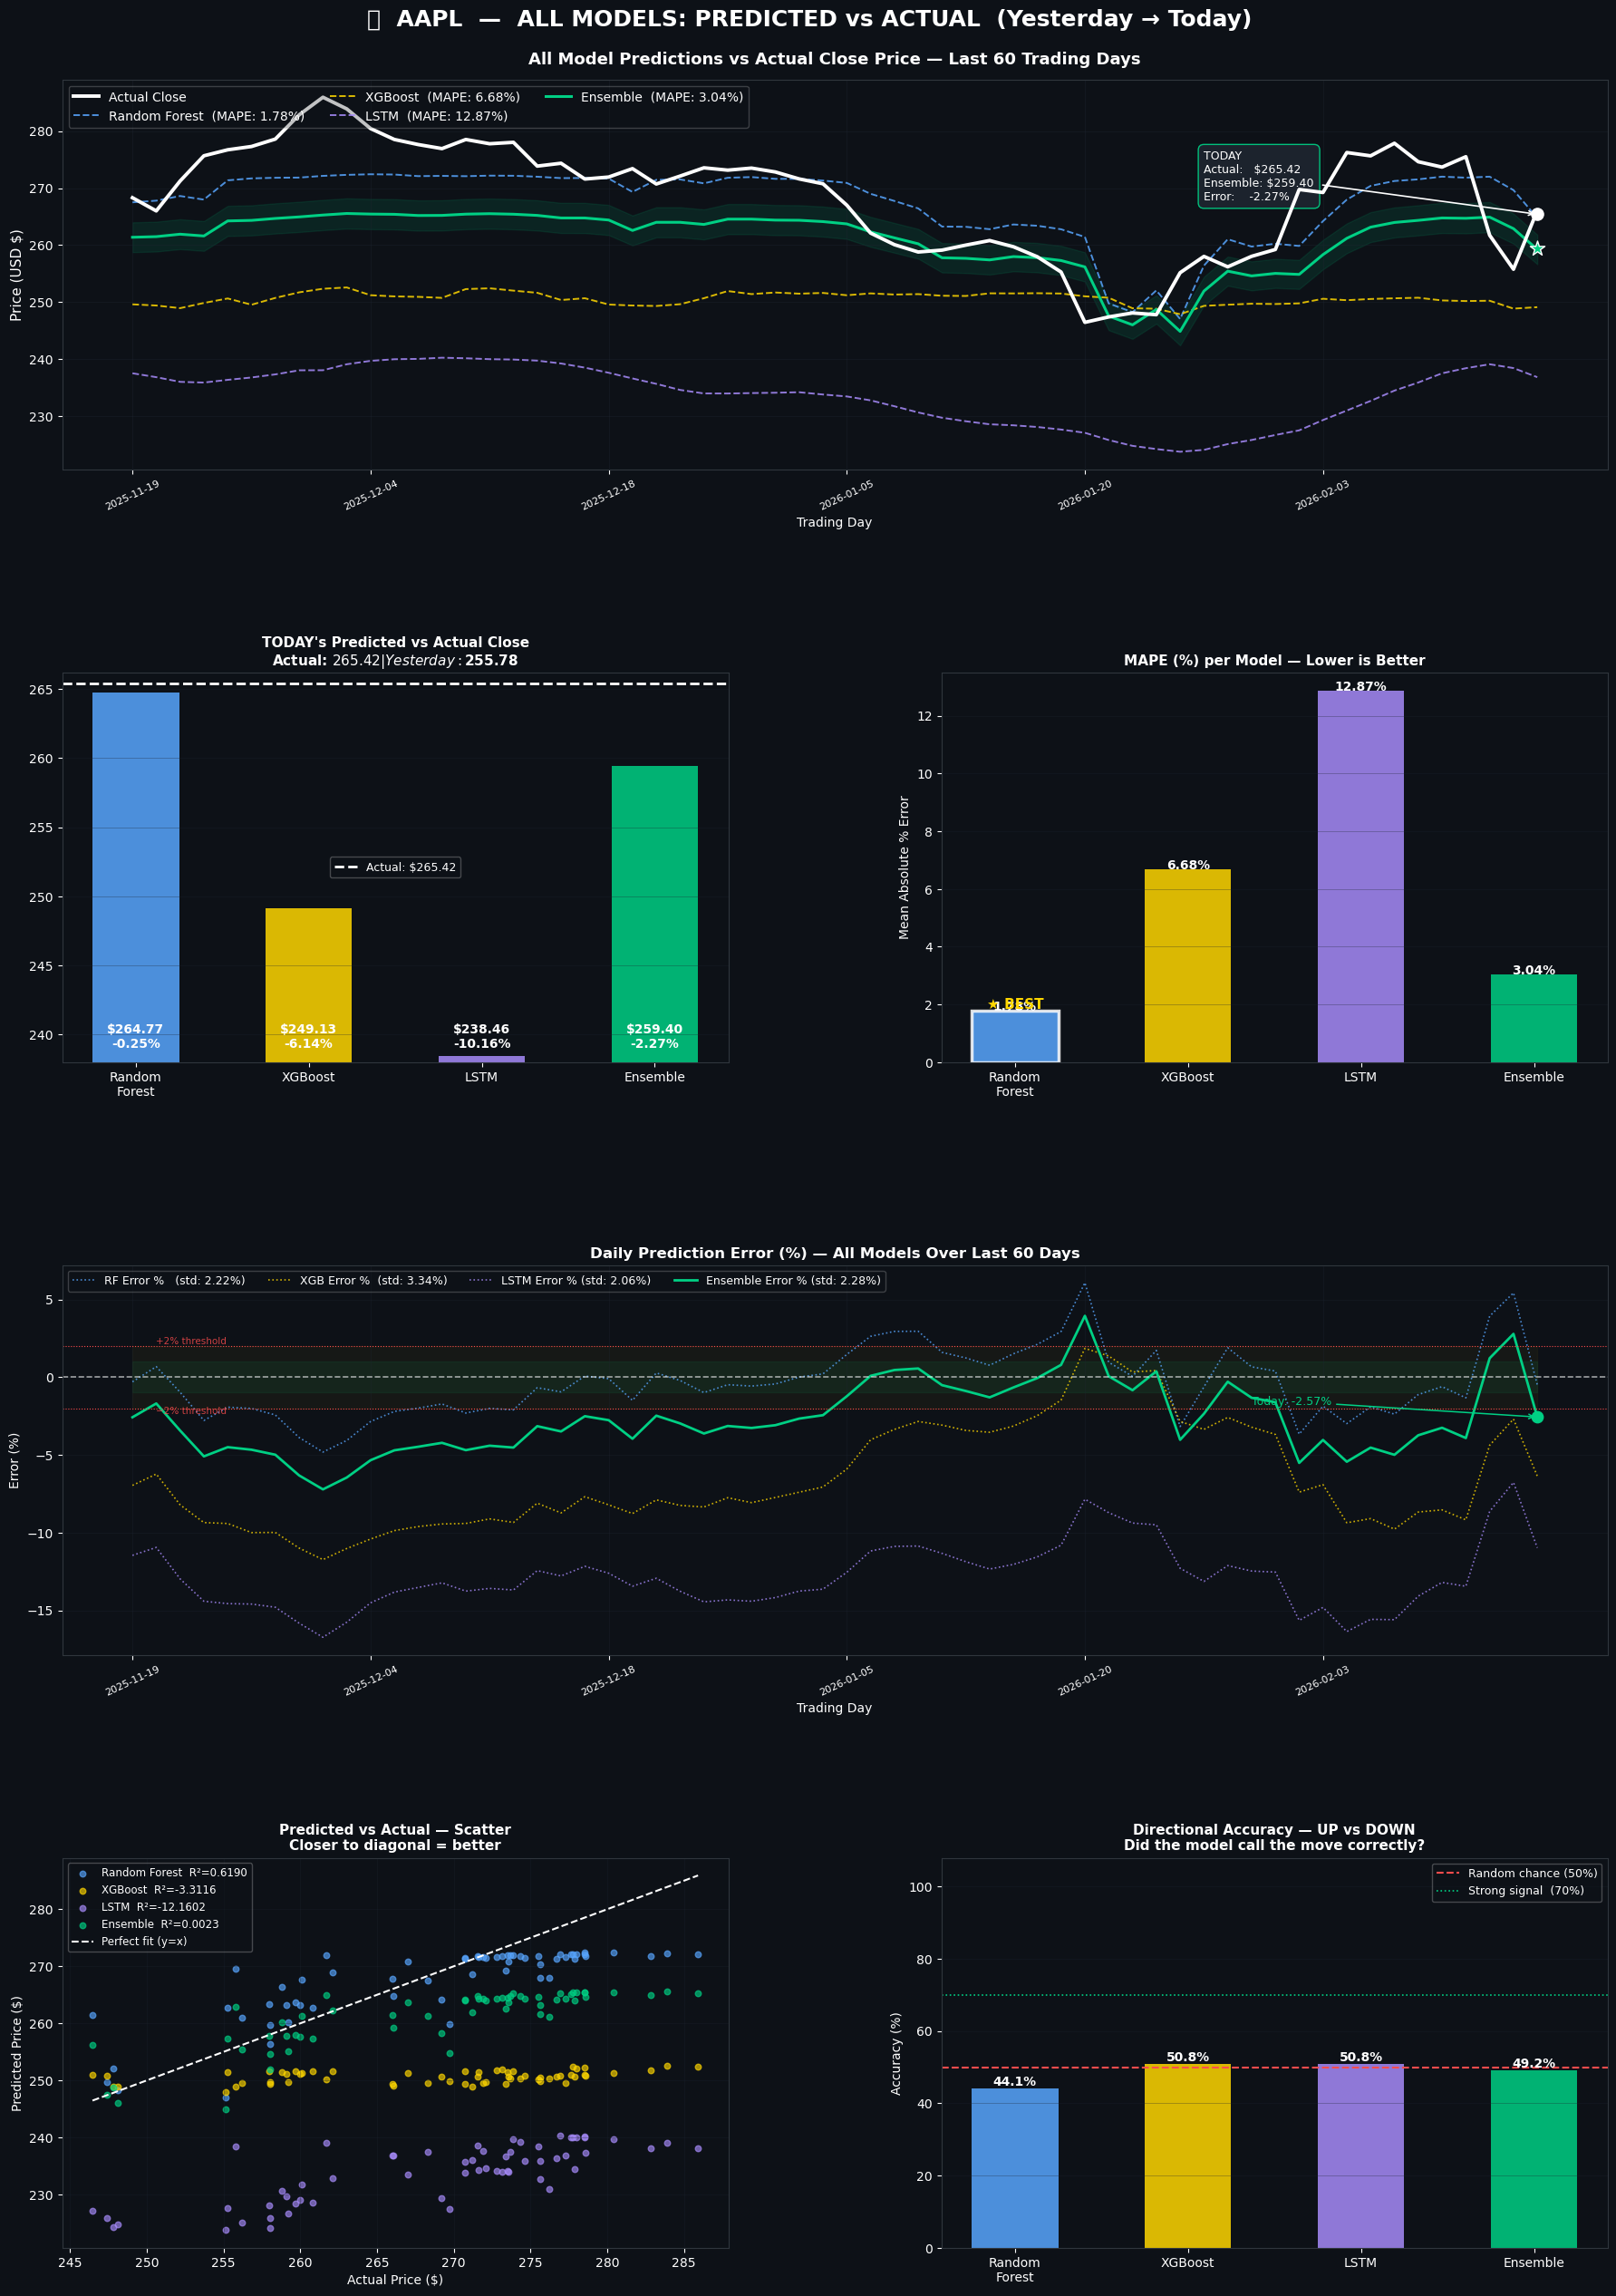

✅ Graph saved as AAPL_Prediction_Comparison.png


In [41]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.metrics import r2_score

# ── Style ──────────────────────────────────────────────────────────────────────
BG    = '#0d1117'
GRID  = '#1e2530'
WHITE = 'white'
C_RF   = '#58a6ff'
C_XGB  = '#ffd700'
C_LSTM = '#a78bfa'
C_ENS  = '#00d084'
C_DN   = '#ff4d4d'

plt.rcParams.update({
    'figure.facecolor': BG, 'axes.facecolor': BG,
    'axes.edgecolor': '#30363d', 'axes.labelcolor': WHITE,
    'xtick.color': WHITE, 'ytick.color': WHITE,
    'text.color': WHITE, 'grid.color': GRID,
    'grid.linewidth': 0.7,
})

# ── Data (already computed in your notebook) ───────────────────────────────────
# rolling_actual, rolling_rf, rolling_xgb, rolling_lstm, rolling_ens → 60-day test arrays
# rolling_dates                                                        → date index
# today_actual_close, pred_rf_today, pred_xgb_today,
# pred_lstm_today, pred_ens_today, yesterday_actual_close             → single-day values

actual   = np.array(rolling_actual)
rf_pred  = np.array(rolling_rf)
xgb_pred = np.array(rolling_xgb)
lstm_pred= np.array(rolling_lstm)
ens_pred = np.array(rolling_ens)
dates    = rolling_dates
x        = np.arange(len(actual))

today_actual = today_actual_close
today_preds  = [pred_rf_today, pred_xgb_today, pred_lstm_today, pred_ens_today]
model_labels = ['Random\nForest', 'XGBoost', 'LSTM', 'Ensemble']
bar_colors   = [C_RF, C_XGB, C_LSTM, C_ENS]

# ── Metrics ────────────────────────────────────────────────────────────────────
def mape(pred, act): return np.mean(np.abs((pred - act) / act)) * 100
mapes = [mape(rf_pred, actual), mape(xgb_pred, actual),
         mape(lstm_pred, actual), mape(ens_pred, actual)]
r2s   = [r2_score(actual, rf_pred), r2_score(actual, xgb_pred),
         r2_score(actual, lstm_pred), r2_score(actual, ens_pred)]

err_rf   = (rf_pred   - actual) / actual * 100
err_xgb  = (xgb_pred  - actual) / actual * 100
err_lstm = (lstm_pred - actual) / actual * 100
err_ens  = (ens_pred  - actual) / actual * 100

actual_dir = np.sign(np.diff(actual))
def dir_acc(pred):
    return np.mean(np.sign(np.diff(pred)) == actual_dir) * 100
daccs = [dir_acc(rf_pred), dir_acc(xgb_pred), dir_acc(lstm_pred), dir_acc(ens_pred)]

# ═══════════════════════════════════════════════════════════════════════════════
# BUILD FIGURE
# ═══════════════════════════════════════════════════════════════════════════════
fig = plt.figure(figsize=(22, 26), facecolor=BG)
fig.suptitle('🍎  AAPL  —  ALL MODELS: PREDICTED vs ACTUAL  (Yesterday → Today)',
             fontsize=18, fontweight='bold', color=WHITE, y=0.99)

gs = gridspec.GridSpec(4, 2, figure=fig, hspace=0.52, wspace=0.32,
                       top=0.96, bottom=0.04)

# ── CHART 1: Main Line Chart ───────────────────────────────────────────────────
ax1 = fig.add_subplot(gs[0, :])

ax1.fill_between(x, ens_pred * 0.99, ens_pred * 1.01, alpha=0.10, color=C_ENS)
ax1.plot(x, actual,    color=WHITE,  lw=2.8,  label='Actual Close', zorder=5)
ax1.plot(x, rf_pred,   color=C_RF,   lw=1.4,  linestyle='--', label=f'Random Forest  (MAPE: {mapes[0]:.2f}%)', alpha=0.85)
ax1.plot(x, xgb_pred,  color=C_XGB,  lw=1.4,  linestyle='--', label=f'XGBoost  (MAPE: {mapes[1]:.2f}%)',       alpha=0.85)
ax1.plot(x, lstm_pred, color=C_LSTM, lw=1.4,  linestyle='--', label=f'LSTM  (MAPE: {mapes[2]:.2f}%)',          alpha=0.85)
ax1.plot(x, ens_pred,  color=C_ENS,  lw=2.2,  label=f'Ensemble  (MAPE: {mapes[3]:.2f}%)',   zorder=4)

# Today marker
ax1.scatter(x[-1], today_actual, color=WHITE, s=90, zorder=10)
ax1.scatter(x[-1], pred_ens_today, color=C_ENS, s=150, marker='*', zorder=11, edgecolors='white', linewidths=1)
ax1.annotate(
    f'TODAY\nActual:   ${today_actual:.2f}\nEnsemble: ${pred_ens_today:.2f}\nError:    {(pred_ens_today - today_actual)/today_actual*100:+.2f}%',
    xy=(x[-1], today_actual), xytext=(x[-1] - 14, today_actual + 2.5),
    arrowprops=dict(arrowstyle='->', color=WHITE, lw=1.2),
    fontsize=9, color=WHITE,
    bbox=dict(boxstyle='round,pad=0.5', facecolor='#1e2530', edgecolor=C_ENS, alpha=0.92)
)

ax1.set_title('All Model Predictions vs Actual Close Price — Last 60 Trading Days',
              color=WHITE, fontsize=13, fontweight='bold', pad=12)
ax1.set_ylabel('Price (USD $)', fontsize=11)
ax1.set_xlabel('Trading Day', fontsize=10)
ax1.legend(loc='upper left', fontsize=10, framealpha=0.25, ncol=3)
ax1.grid(True, alpha=0.4)

# Use dates on x-axis if available
tick_positions = x[::10]
ax1.set_xticks(tick_positions)
ax1.set_xticklabels([str(dates[i].date()) if hasattr(dates[i], 'date') else str(dates[i])
                     for i in tick_positions], rotation=25, fontsize=8)

# ── CHART 2: Today's bar chart ─────────────────────────────────────────────────
ax2 = fig.add_subplot(gs[1, 0])

y_min = min(today_preds + [today_actual]) * 0.998
y_max = max(today_preds + [today_actual]) * 1.003
bars = ax2.bar(model_labels, today_preds, color=bar_colors, width=0.5, alpha=0.85, edgecolor='none')
ax2.set_ylim(y_min, y_max)
ax2.axhline(today_actual, color=WHITE, lw=2, linestyle='--', label=f'Actual: ${today_actual:.2f}')

for bar, val in zip(bars, today_preds):
    err_pct = (val - today_actual) / today_actual * 100
    err_clr = C_ENS if err_pct >= 0 else C_DN
    ax2.text(bar.get_x() + bar.get_width()/2, y_min + (y_max - y_min) * 0.03,
             f'${val:.2f}\n{err_pct:+.2f}%',
             ha='center', va='bottom', fontsize=10, color=WHITE, fontweight='bold')

ax2.set_title(f"TODAY's Predicted vs Actual Close\nActual: ${today_actual:.2f}  |  Yesterday: ${yesterday_actual_close:.2f}",
              color=WHITE, fontsize=11, fontweight='bold')
ax2.legend(fontsize=9, framealpha=0.3)
ax2.grid(True, alpha=0.3, axis='y')

# ── CHART 3: MAPE bar ──────────────────────────────────────────────────────────
ax3 = fig.add_subplot(gs[1, 1])

bars3 = ax3.bar(model_labels, mapes, color=bar_colors, width=0.5, alpha=0.85, edgecolor='none')
best_i = int(np.argmin(mapes))
bars3[best_i].set_edgecolor('white')
bars3[best_i].set_linewidth(2.5)

for bar, val in zip(bars3, mapes):
    ax3.text(bar.get_x() + bar.get_width()/2, val + 0.005,
             f'{val:.2f}%', ha='center', fontsize=10, color=WHITE, fontweight='bold')

ax3.text(bars3[best_i].get_x() + bars3[best_i].get_width()/2,
         mapes[best_i] + 0.07, '★ BEST', ha='center', fontsize=11, color='#ffd700', fontweight='bold')

ax3.set_title('MAPE (%) per Model — Lower is Better', color=WHITE, fontsize=11, fontweight='bold')
ax3.set_ylabel('Mean Absolute % Error', fontsize=10)
ax3.grid(True, alpha=0.3, axis='y')

# ── CHART 4: Error % timeline ──────────────────────────────────────────────────
ax4 = fig.add_subplot(gs[2, :])

ax4.fill_between(x, -1,  1, alpha=0.07, color=C_ENS)
ax4.fill_between(x, -2,  2, alpha=0.04, color=C_XGB)
ax4.plot(x, err_rf,   color=C_RF,   lw=1.2, linestyle=':', alpha=0.8, label=f'RF Error %   (std: {err_rf.std():.2f}%)')
ax4.plot(x, err_xgb,  color=C_XGB,  lw=1.2, linestyle=':', alpha=0.8, label=f'XGB Error %  (std: {err_xgb.std():.2f}%)')
ax4.plot(x, err_lstm, color=C_LSTM, lw=1.2, linestyle=':', alpha=0.8, label=f'LSTM Error % (std: {err_lstm.std():.2f}%)')
ax4.plot(x, err_ens,  color=C_ENS,  lw=2.0, label=f'Ensemble Error % (std: {err_ens.std():.2f}%)')

ax4.axhline(0,  color=WHITE, lw=1.2, linestyle='--', alpha=0.6)
ax4.axhline( 2, color=C_DN,  lw=0.8, linestyle=':')
ax4.axhline(-2, color=C_DN,  lw=0.8, linestyle=':')
ax4.text(1,  2.15, '+2% threshold', fontsize=7.5, color=C_DN, alpha=0.8)
ax4.text(1, -2.35, '−2% threshold', fontsize=7.5, color=C_DN, alpha=0.8)

# Today marker
ax4.scatter(x[-1], err_ens[-1], color=C_ENS, s=80, zorder=10)
ax4.annotate(f'Today: {err_ens[-1]:+.2f}%',
             xy=(x[-1], err_ens[-1]), xytext=(x[-1]-12, err_ens[-1]+0.8),
             fontsize=9, color=C_ENS,
             arrowprops=dict(arrowstyle='->', color=C_ENS, lw=1.1))

ax4.set_title('Daily Prediction Error (%) — All Models Over Last 60 Days',
              color=WHITE, fontsize=12, fontweight='bold')
ax4.set_ylabel('Error (%)', fontsize=10)
ax4.set_xlabel('Trading Day', fontsize=10)
ax4.legend(loc='upper left', fontsize=9, framealpha=0.25, ncol=4)
ax4.grid(True, alpha=0.35)
ax4.set_xticks(tick_positions)
ax4.set_xticklabels([str(dates[i].date()) if hasattr(dates[i], 'date') else str(dates[i])
                     for i in tick_positions], rotation=25, fontsize=8)

# ── CHART 5: Scatter predicted vs actual ──────────────────────────────────────
ax5 = fig.add_subplot(gs[3, 0])

for pred, color, name, r2 in zip(
    [rf_pred, xgb_pred, lstm_pred, ens_pred],
    bar_colors, ['Random Forest','XGBoost','LSTM','Ensemble'], r2s
):
    ax5.scatter(actual, pred, color=color, s=22, alpha=0.65, label=f'{name}  R²={r2:.4f}')

perfect = np.linspace(actual.min(), actual.max(), 100)
ax5.plot(perfect, perfect, color=WHITE, lw=1.5, linestyle='--', label='Perfect fit (y=x)')
ax5.set_title('Predicted vs Actual — Scatter\nCloser to diagonal = better',
              color=WHITE, fontsize=11, fontweight='bold')
ax5.set_xlabel('Actual Price ($)', fontsize=10)
ax5.set_ylabel('Predicted Price ($)', fontsize=10)
ax5.legend(fontsize=8.5, framealpha=0.3)
ax5.grid(True, alpha=0.3)

# ── CHART 6: Directional accuracy ─────────────────────────────────────────────
ax6 = fig.add_subplot(gs[3, 1])

bars6 = ax6.bar(model_labels, daccs, color=bar_colors, width=0.5, alpha=0.85, edgecolor='none')
ax6.axhline(50, color=C_DN,  lw=1.5, linestyle='--', label='Random chance (50%)')
ax6.axhline(70, color=C_ENS, lw=1.2, linestyle=':',  label='Strong signal  (70%)')

for bar, val in zip(bars6, daccs):
    ax6.text(bar.get_x() + bar.get_width()/2, val + 0.8,
             f'{val:.1f}%', ha='center', fontsize=10, color=WHITE, fontweight='bold')

ax6.set_ylim(0, 108)
ax6.set_title('Directional Accuracy — UP vs DOWN\nDid the model call the move correctly?',
              color=WHITE, fontsize=11, fontweight='bold')
ax6.set_ylabel('Accuracy (%)', fontsize=10)
ax6.legend(fontsize=9, framealpha=0.3)
ax6.grid(True, alpha=0.3, axis='y')

plt.savefig('AAPL_Prediction_Comparison.png', dpi=150, bbox_inches='tight', facecolor=BG)
plt.show()
print("✅ Graph saved as AAPL_Prediction_Comparison.png")